# 1. Fitting Ne lines in a loop
- This is the first step of fitting Diad data
- This notebook shows how to fit all lines in a folder defined by path
- You tweak the fit for a single line, and then use this to fit all lines. You can then refit lines with high residuals/offsets differing from the rest

## Downloading locally
- You can install DiadFit through PyPI, simply uncomment this line. You only need to run this once per computer (until you want to get an upgraded version)
- Uncomment this line if you havent installed DiadFit, or are running a much older version. 

In [1]:
# %pip install --upgrade DiadFit

## Now import the packages you need
- When you communicate bugs with Penny, make sure you specify the version here.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import DiadFit as pf
# This needs to be 0.0.68 or higher!
pf.__version__

'0.0.78'

##  Specifying paths
- Put your path here, e.g. where in your computer the spectra and metadata are saved

In [3]:
import os
DayFolder=os.getcwd()
meta_path=DayFolder +  '\MetaData'
spectra_path=DayFolder + '\Spectra'
filetype='headless_txt'
# What is your file extension? .txt, .csv, .xlsx?
file_ext='.txt'
# Does your file start with a prefix? E.g 01 Ne_line.txt?
prefix=True
prefix_str=' '

# Does your instrument have TruPower (WITEC)
TruPower=True
# Save settings to a file to use in all other notebooks
pf.save_settings(meta_path, spectra_path, filetype, prefix, prefix_str, file_ext, TruPower)


In [4]:
# This step gets all your Ne files. Enter ID_str as a string in only your Neon files, exclude strings not in Ne files. So here we take files with 'Ne' in the name and exclude those with 'diad' in the name. 
Ne_files=pf.get_files(path=spectra_path,
file_ext='txt', ID_str='Ne', 
exclude_str=['diad'], sort=False)

Ne_files

['01 Ne1.txt',
 '03 Ne2.txt',
 '04 LL4-FI5-rep2+Ne3.txt',
 '06 Ne4.txt',
 '08 Ne5.txt',
 '10 Ne6.txt',
 '13 Ne7.txt',
 '19 Ne8.txt',
 '24 Ne9.txt',
 '31 Ne10.txt',
 '33 Ne11.txt',
 '35 Ne12.txt',
 '41 Ne13.txt',
 '45 Ne14.txt',
 '50 Ne15.txt',
 '54 Ne16.txt']

### Get Ne line positions for your specific laser wavelength
- At the moment, this returns any Ne lines with intensity >2000 in the NIST databook, although you can change this!

In [5]:
wavelength =532.046 # Specify the specific wavelength of your laser 
df_Ne=pf.calculate_Ne_line_positions(wavelength=wavelength, 
cut_off_intensity=2000)
df_Ne.head()

Raman_shift (cm-1)  Intensity  Ne emission line in air
1           818.699523     5000.0                556.27662
9          1117.086987     5000.0                565.66588
16         1310.480205     5000.0                571.92248
19         1398.915133     5000.0                574.82985
23         1447.564622     7000.0                576.44188

### Calculate the ideal distance between the two lines you are selecting
- This finds the closest line in the table above for each selected line

In [6]:
line_1=1117
line_2=1447
ideal_split=pf.calculate_Ne_splitting(wavelength=wavelength, 
line1_shift=line_1, line2_shift=line_2,
cut_off_intensity=2000)
ideal_split

Ne_Split       Line_1       Line_2  Entered Pos Line 1  \
0  330.477634  1117.086987  1447.564622                1117   

   Entered Pos Line 2  
0                1447

## Select one file to tweak the fit for
- You can either do this numerically, or by specifiying the filename between ''

In [7]:
i=0 # Select one file
filename=Ne_files[i] 
print(filename)

01 Ne1.txt


## Plot Ne lines to inspect
- This function allows you to inspect your spectra, and also uses scipy find peaks to get a first guess of the peak positions, which speeds up the voigt fitting in the later part of the notebook
- This also prints the heights of the other peaks so you could choose other Neons if you wanted to

Peak1_cent  Peak1_height   Peak2_cent  Peak2_height   Peak1_prom  \
0  1116.16583   4193.666504  1447.138537   45490.33203  3493.766504   

    Peak2_prom  
0  44790.43203

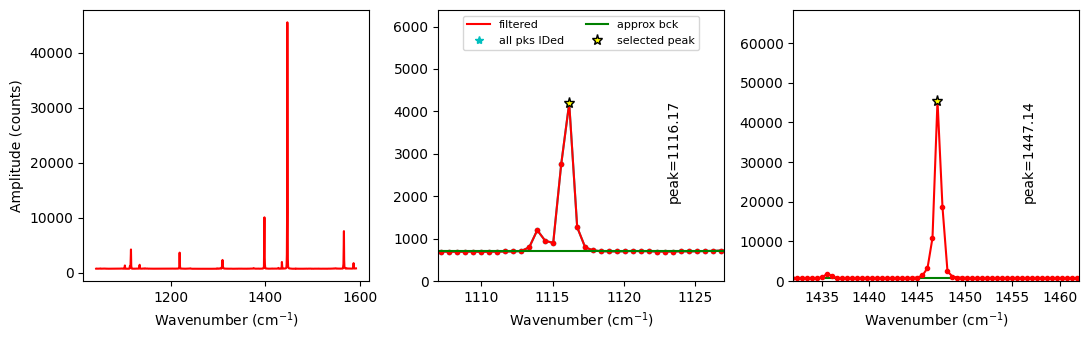

In [8]:
exclude_range_1=None
exclude_range_2=None

Neon_id_config=pf.Neon_id_config(height=10,  distance=1, prominence=10, 
            width=1, threshold=0.6,
            peak1_cent=line_1, peak2_cent=line_2, n_peaks=6, 
            exclude_range_1=exclude_range_1, 
            exclude_range_2=exclude_range_2)
Neon_id_config

Ne, df_fit_params=pf.identify_Ne_lines(path=spectra_path,
filename=filename, filetype=filetype,
config=Neon_id_config, print_df=False)
df_fit_params

### Tweak peak parameters
- One important thing is the background positions, these are defined relative to the peak position. Once you tweak them for each instrument, you chould be good to go. 
- Another thing is how many peaks you want for Peak1, 'peaks_1', for the 1117 line, you'll need 2 if you have the clear secondary peak seen above. 

In [9]:
pf.Ne_peak_config()

Ne_peak_config(model_name='PseudoVoigtModel', N_poly_pk1_baseline=1, N_poly_pk2_baseline=1, lower_bck_pk1=(-50, -25), upper_bck1_pk1=(8, 15), upper_bck2_pk1=(30, 50), lower_bck_pk2=(-44.2, -22), upper_bck1_pk2=(15, 50), upper_bck2_pk2=(50, 51), peaks_1=2, DeltaNe_ideal=330.477634, x_range_baseline_pk1=20, y_range_baseline_pk1=200, x_range_baseline_pk2=20, y_range_baseline_pk2=200, pk1_sigma=0.4, pk2_sigma=0.4, x_range_peak=15, x_range_residual=7, LH_offset_mini=(1.5, 3), x_span_pk1=None, x_span_pk2=None)

In [10]:
model_name='PseudoVoigtModel'
Ne_Config_est=pf.Ne_peak_config(model_name=model_name,
 DeltaNe_ideal=ideal_split['Ne_Split'], peaks_1=2, LH_offset_mini=[0.5, 3],
pk1_sigma=0.6, pk2_sigma=0.3,
lower_bck_pk1=(-40, -25), upper_bck1_pk1=[40, 70], upper_bck2_pk1=[40, 70],
lower_bck_pk2=[-40, -30], upper_bck1_pk2=[10, 15], upper_bck2_pk2=[25, 40],
x_range_peak=5, x_span_pk1=[-10, 8], x_span_pk2=[-10, 10],
N_poly_pk2_baseline=2 )

filename  1σ_Ne_Corr_test  1σ_Ne_Corr  pk2_peak_cent  pk2_amplitude  \
0  Ne1.txt          0.00004     0.00004    1447.207055   42916.280925   

   pk2_sigma pk2_gamma  error_pk2  Peak2_Prop_Lor  pk1_peak_cent  ...  \
0   0.384944      None    0.00288          0.3819    1116.003791  ...   

   pk1_gamma  error_pk1 Peak1_Prop_Lor     deltaNe   Ne_Corr  Ne_Corr_min  \
0       None   0.013096       0.268571  331.203264  0.997809     0.997761   

   Ne_Corr_max  residual_pk2  residual_pk1  residual_pk1+pk2  
0     0.997857    100.973139      8.626537        109.599676  

[1 rows x 22 columns]

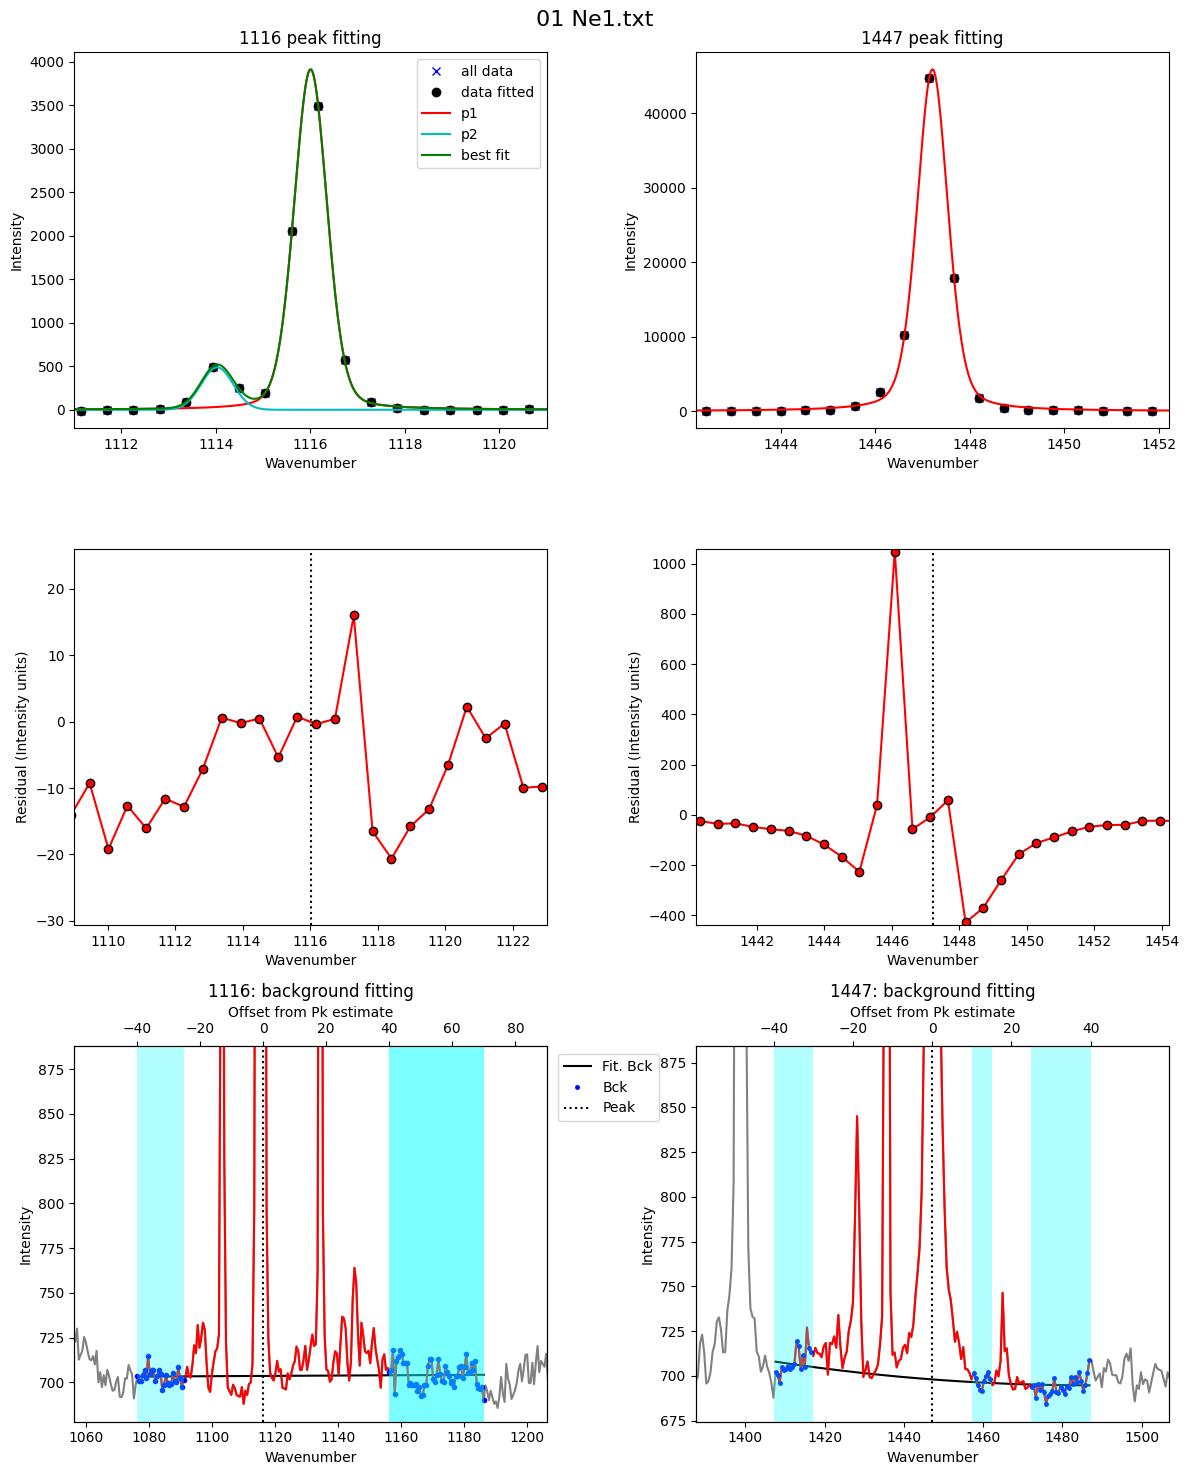

In [11]:

df_test_params=pf.fit_Ne_lines(Ne=Ne, filename=filename,
path=spectra_path, prefix=prefix,
config=Ne_Config_est,
    Ne_center_1=df_fit_params['Peak1_cent'].iloc[0], 
    Ne_center_2=df_fit_params['Peak2_cent'].iloc[0],
    Ne_prom_1=df_fit_params['Peak1_prom'].iloc[0],
    Ne_prom_2=df_fit_params['Peak2_prom'].iloc[0],
    const_params=False)                                                                 
                                                                     
display(df_test_params)

In [12]:
## Now tweak the values of the sigma to help with the looping - then for looping we let these parameters only vary +-20% between spectra
Ne_Config_est.pk1_sigma=df_test_params['pk1_sigma'][0]
Ne_Config_est.pk2_sigma=df_test_params['pk2_sigma'][0]


## Now fit all Ne files here using these parameters. 
- If you select plot_figure=False, the loop will be quick. 
- But if its True, you can to inspect the figures.

  0%|          | 0/16 [00:00<?, ?it/s]

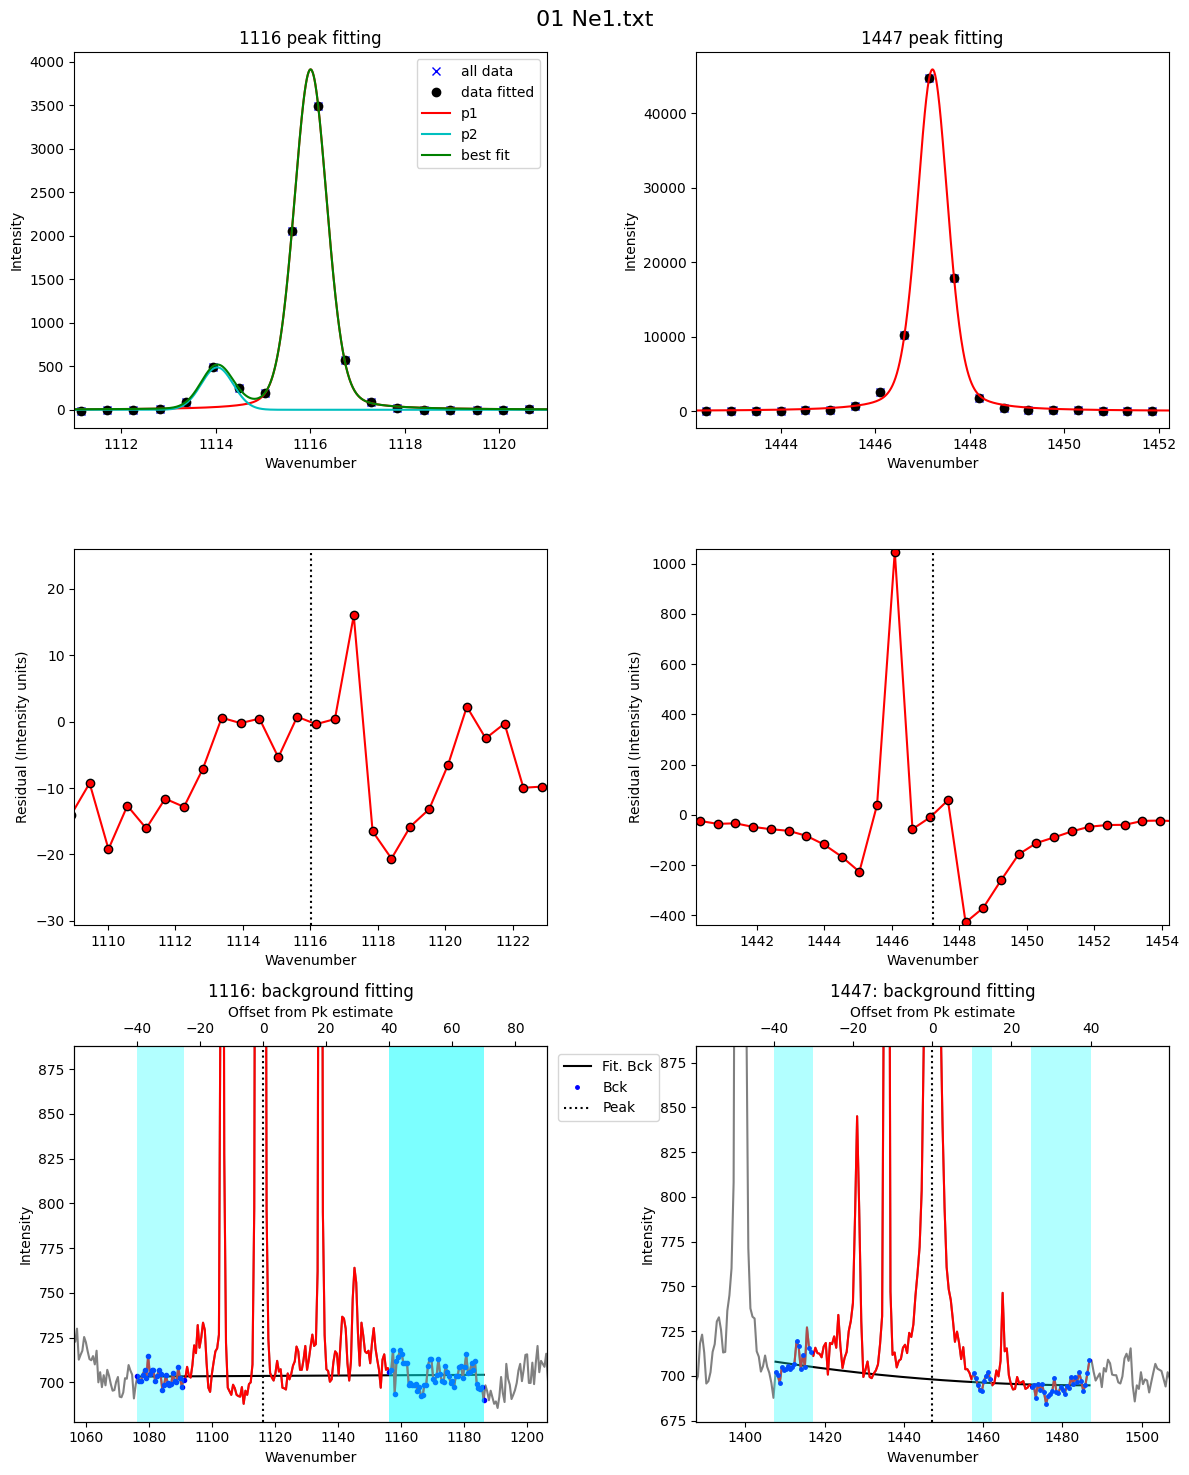

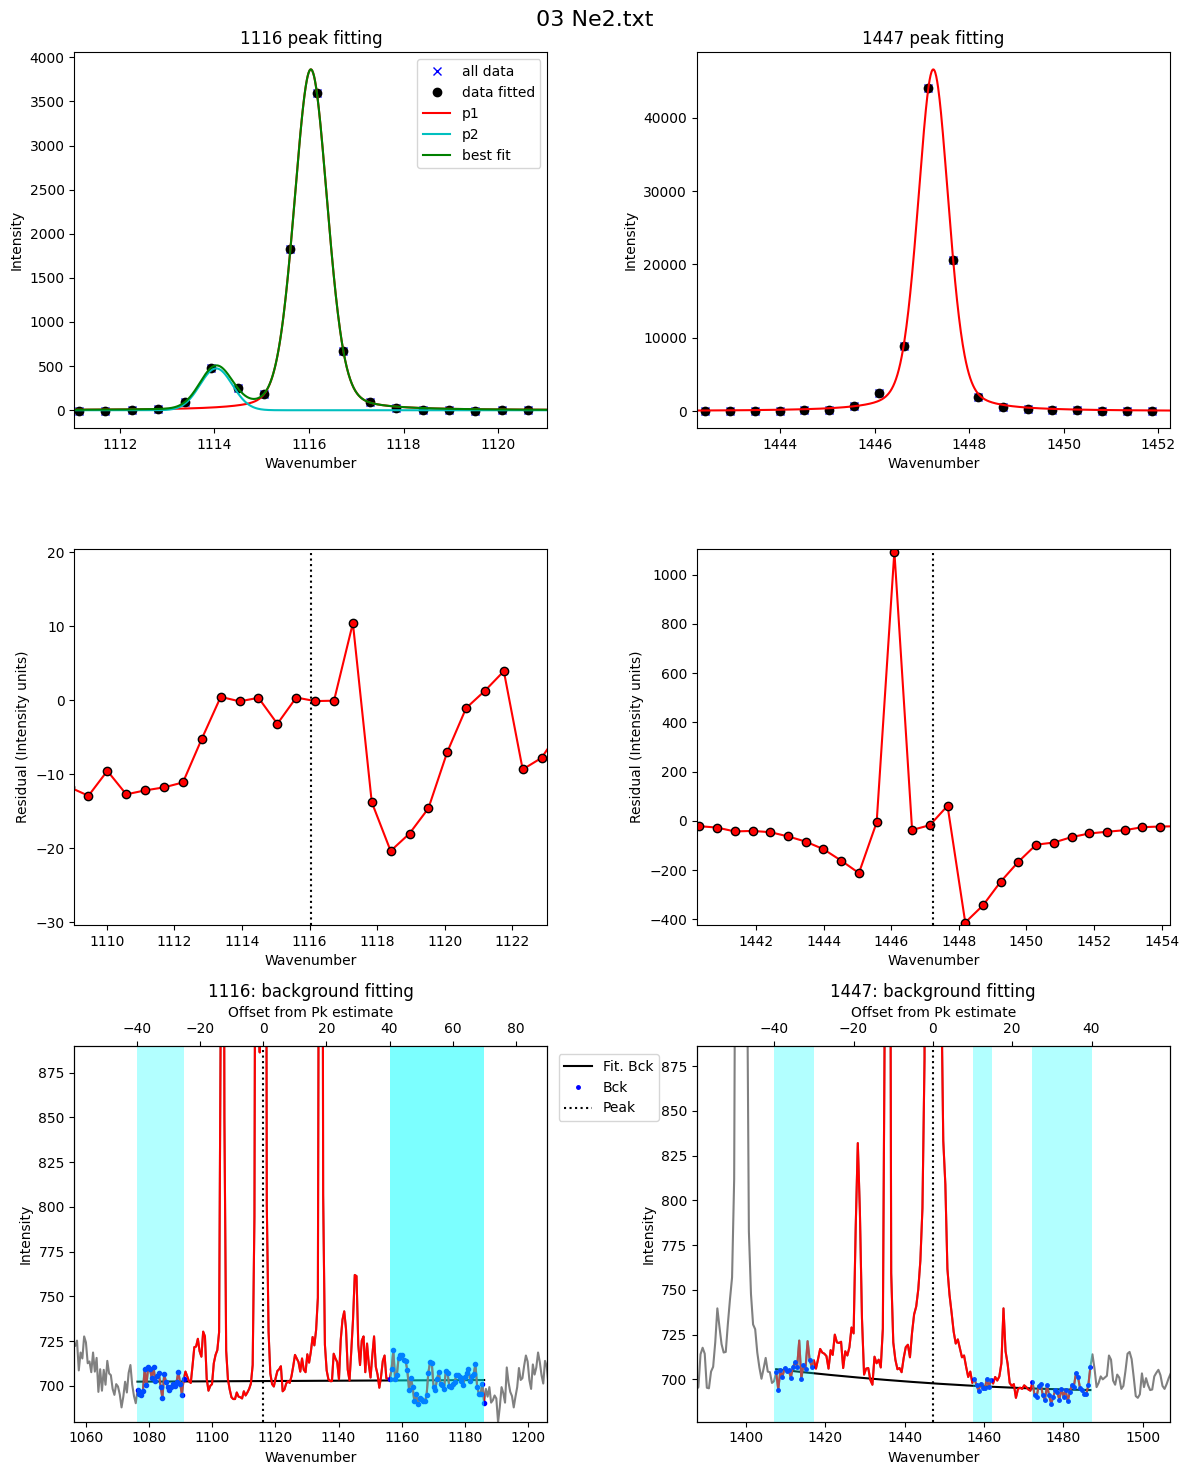

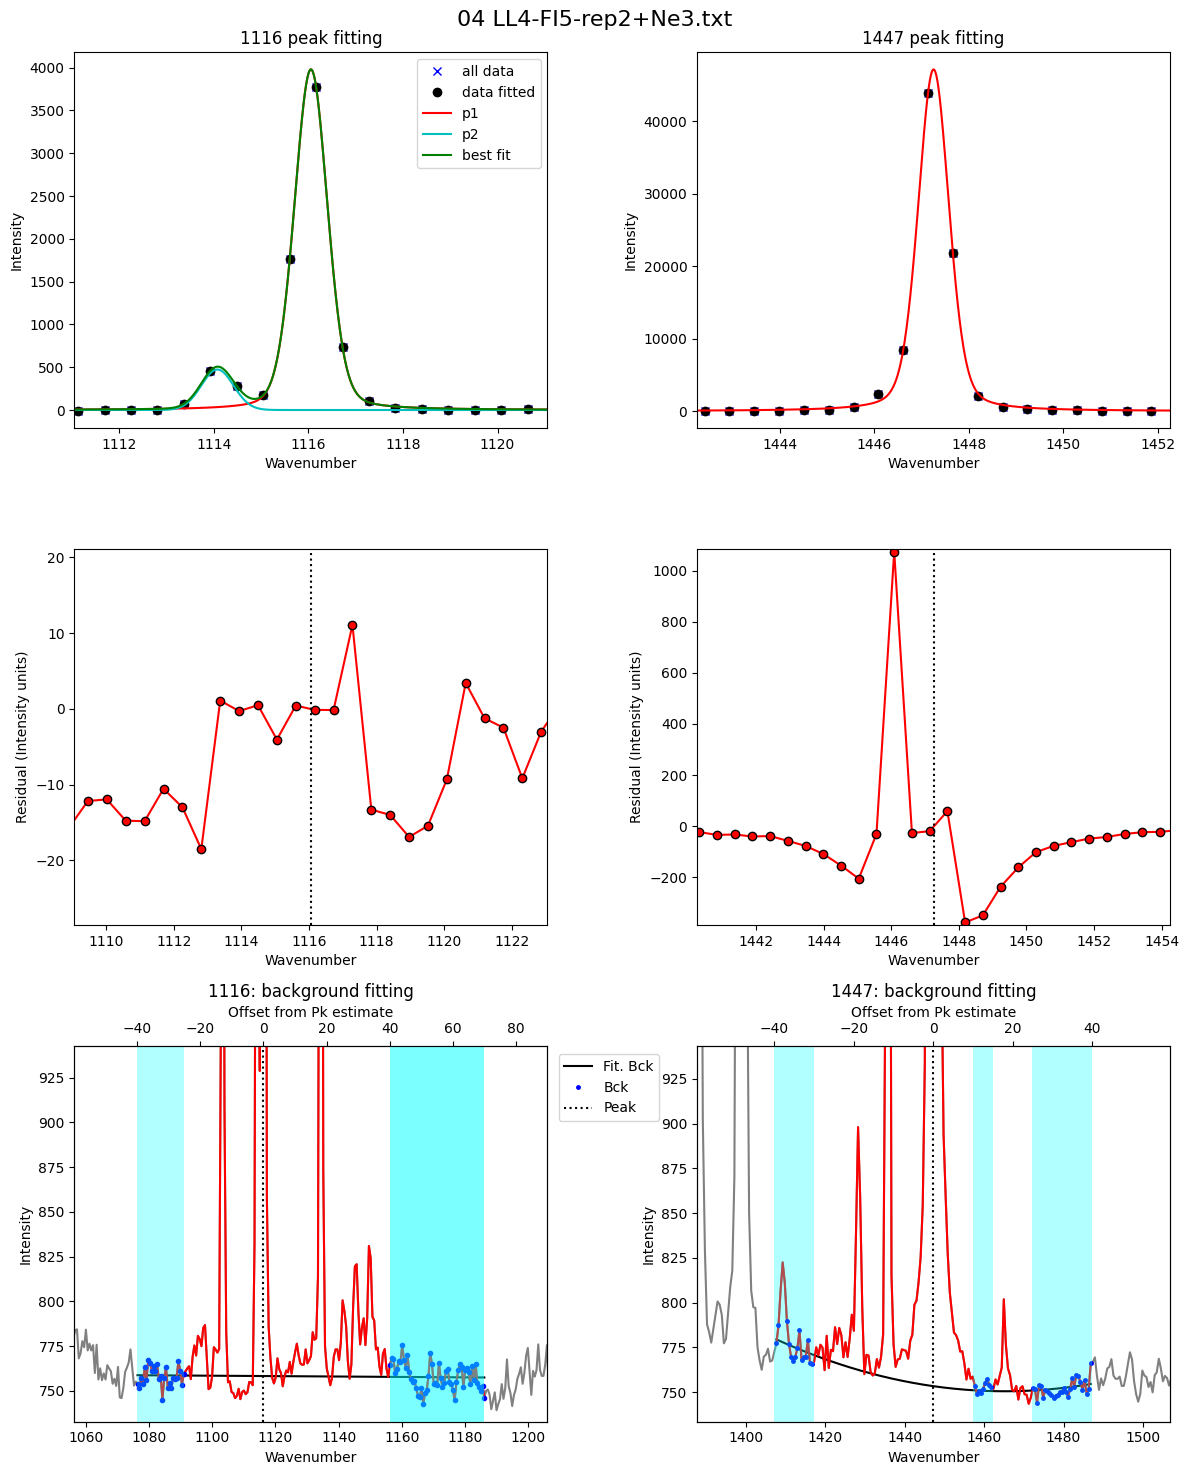

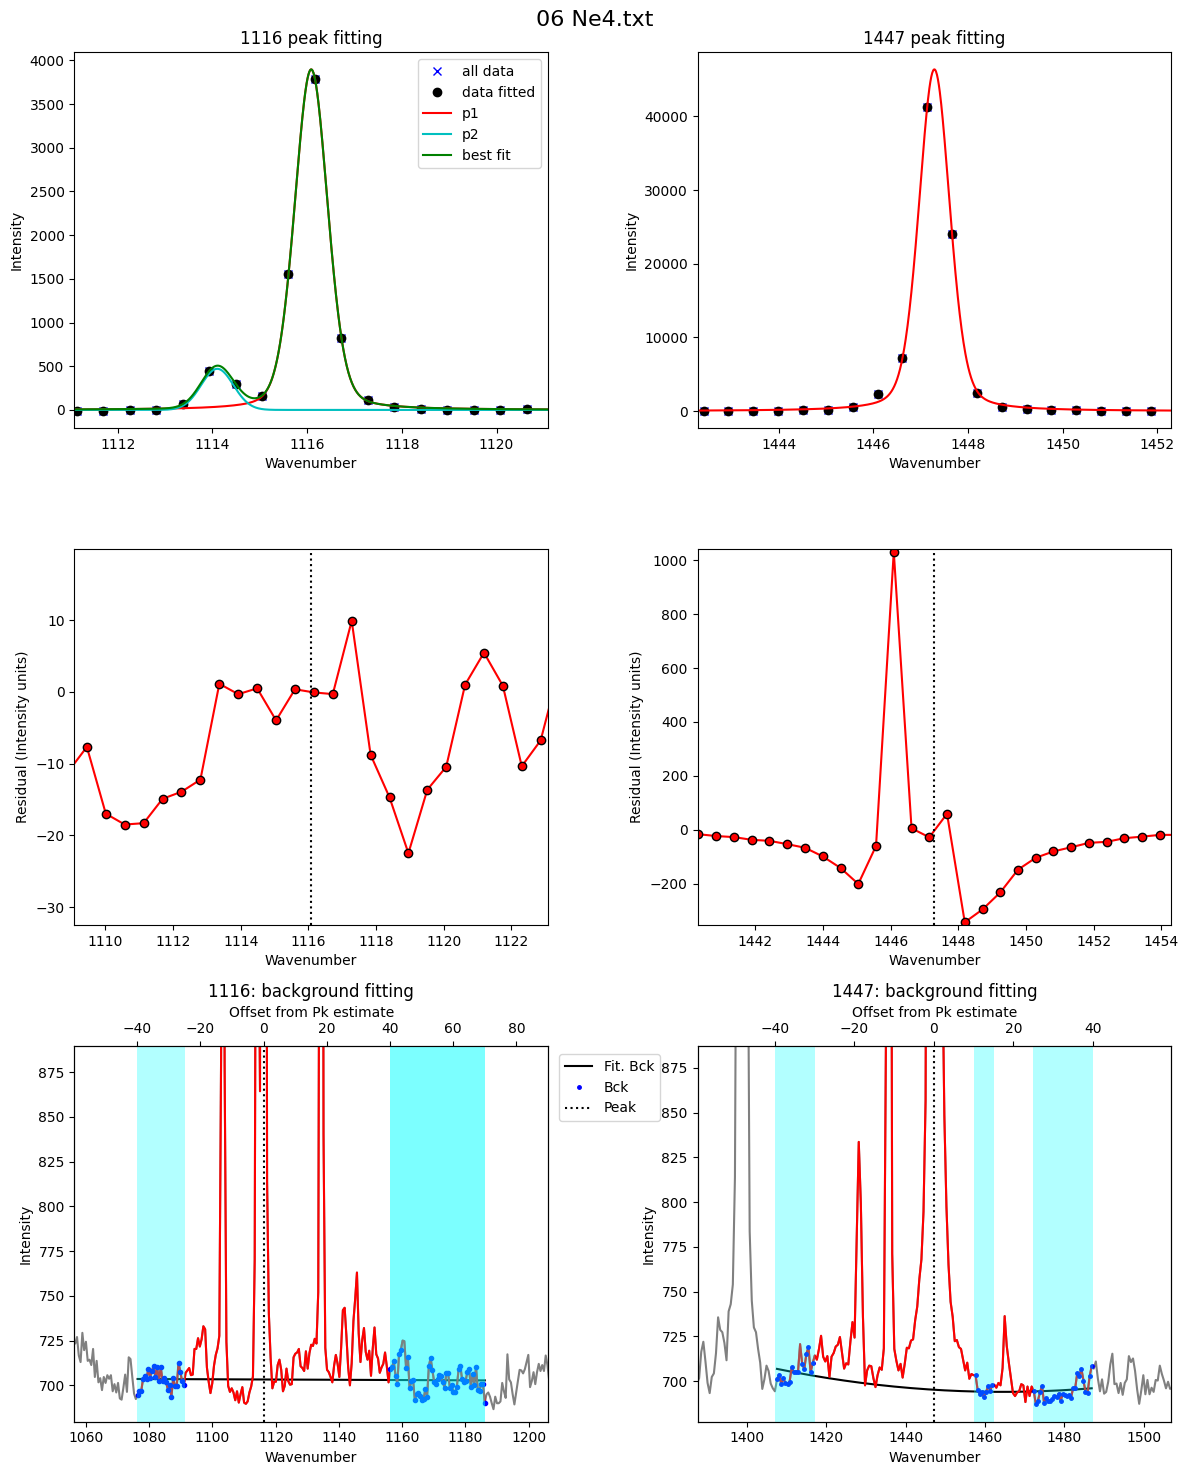

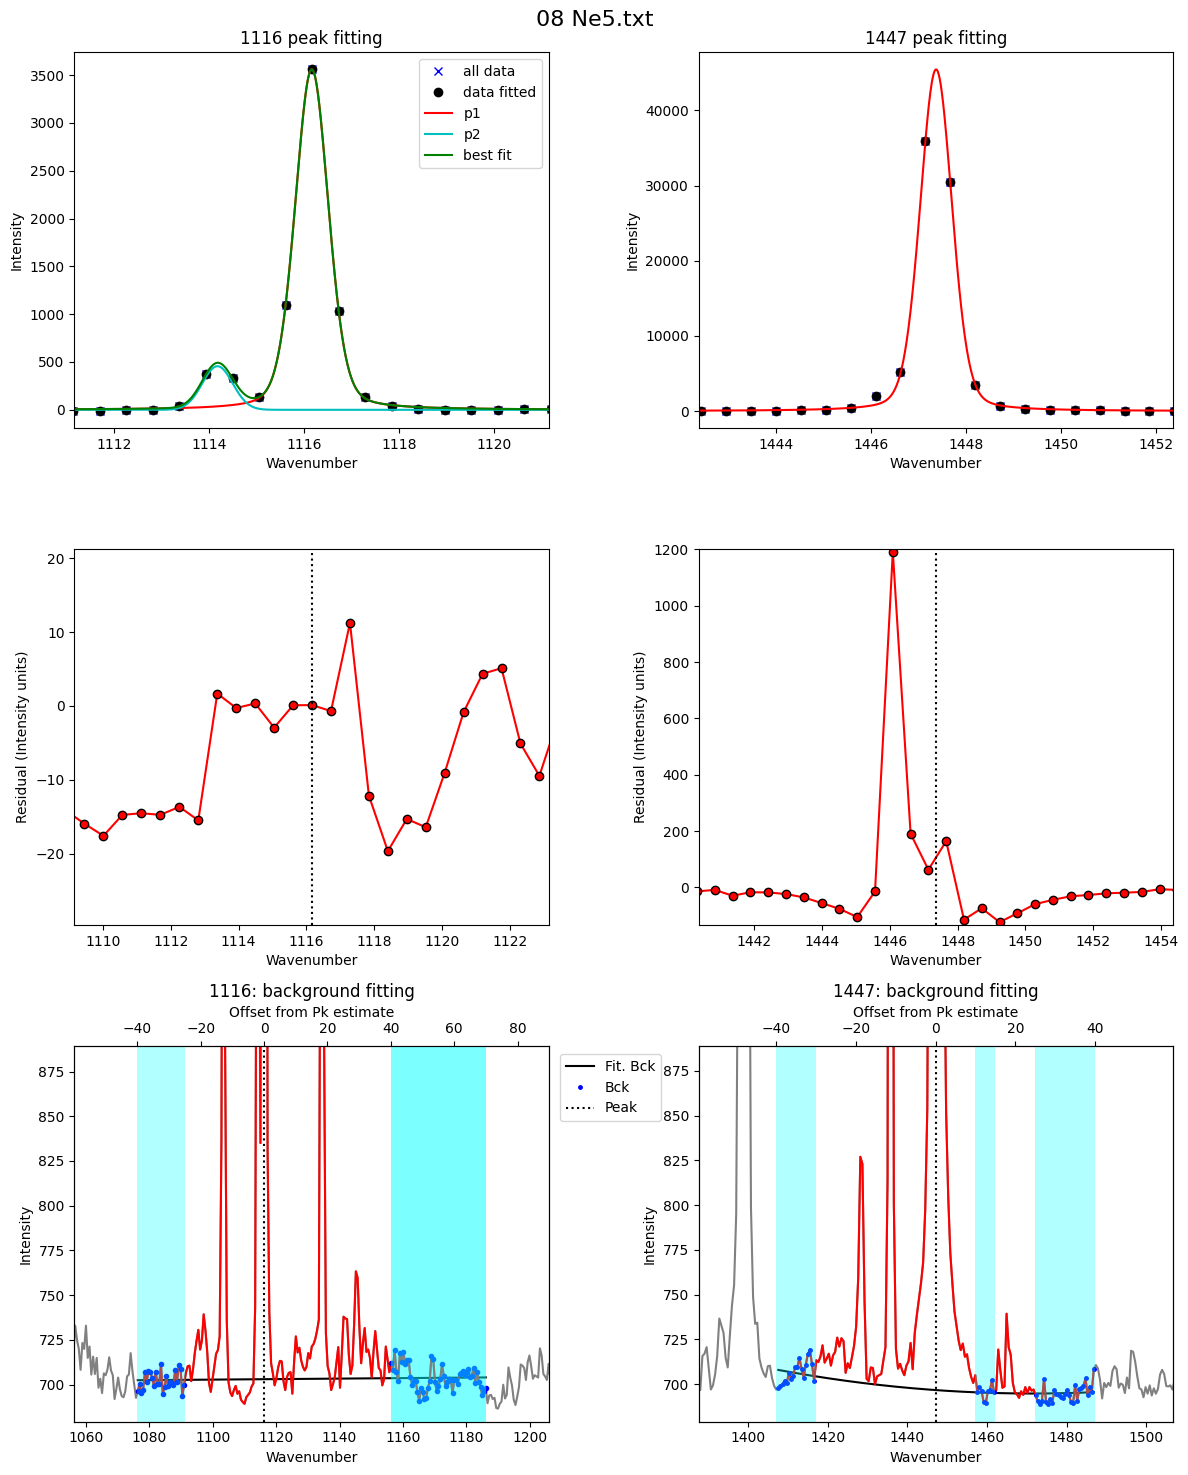

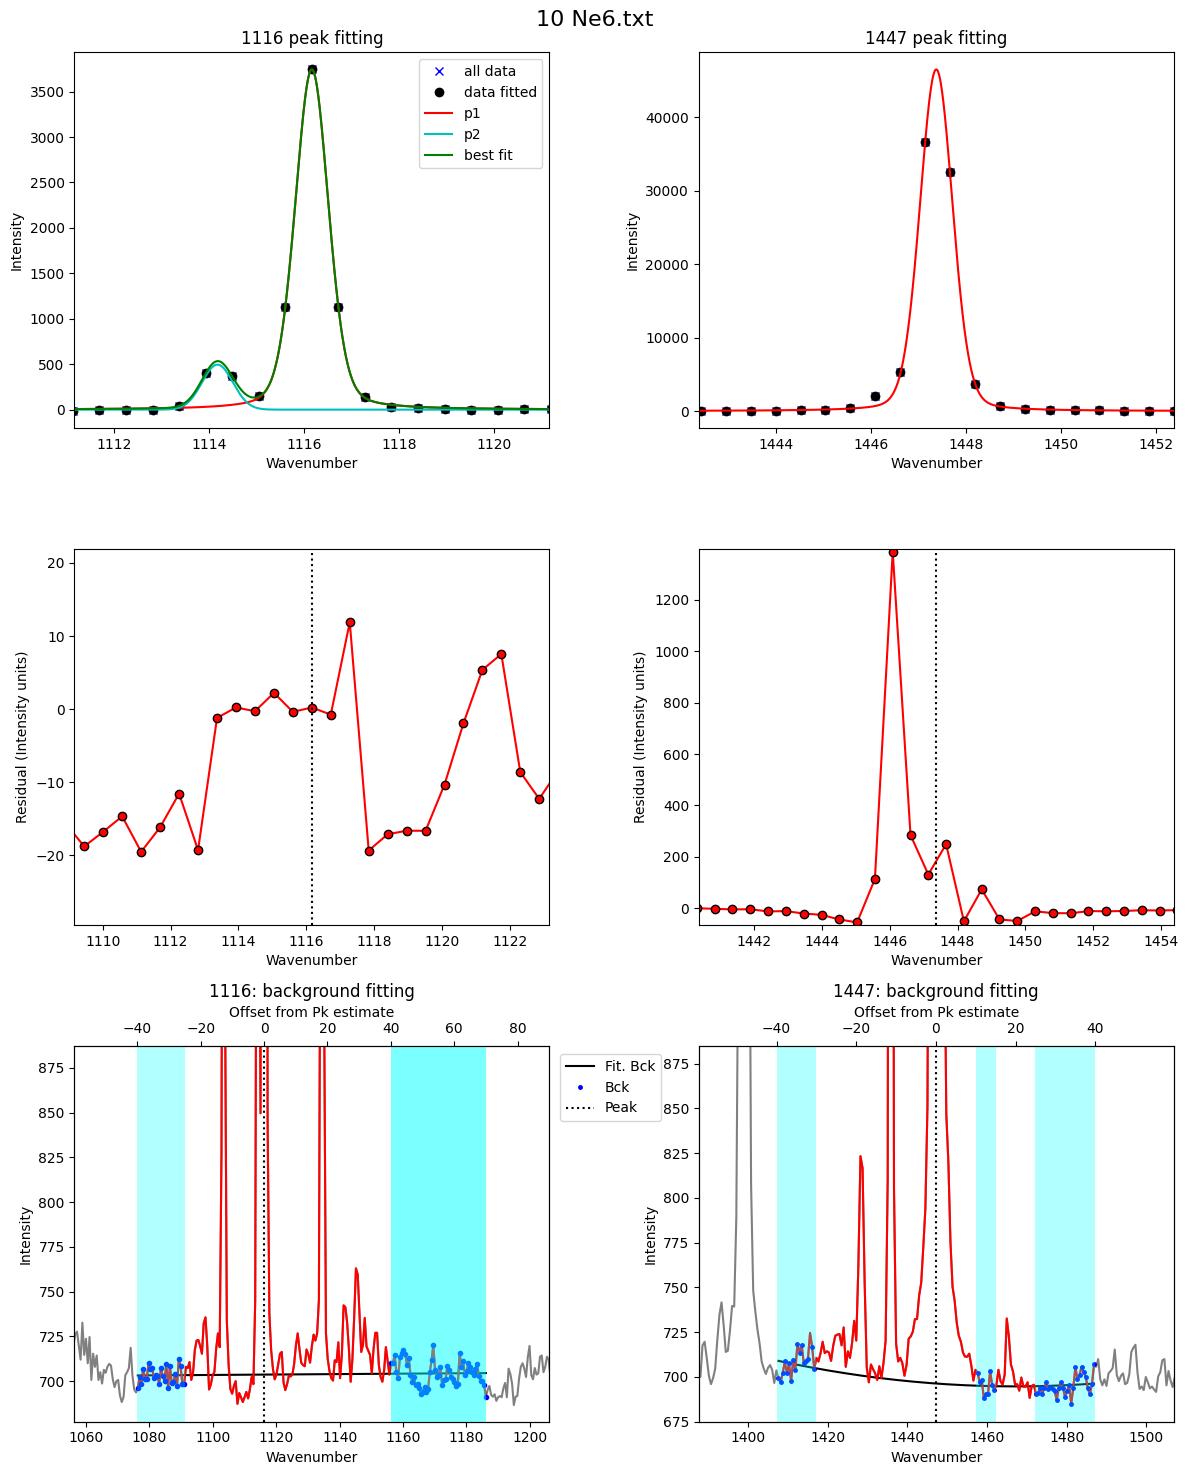

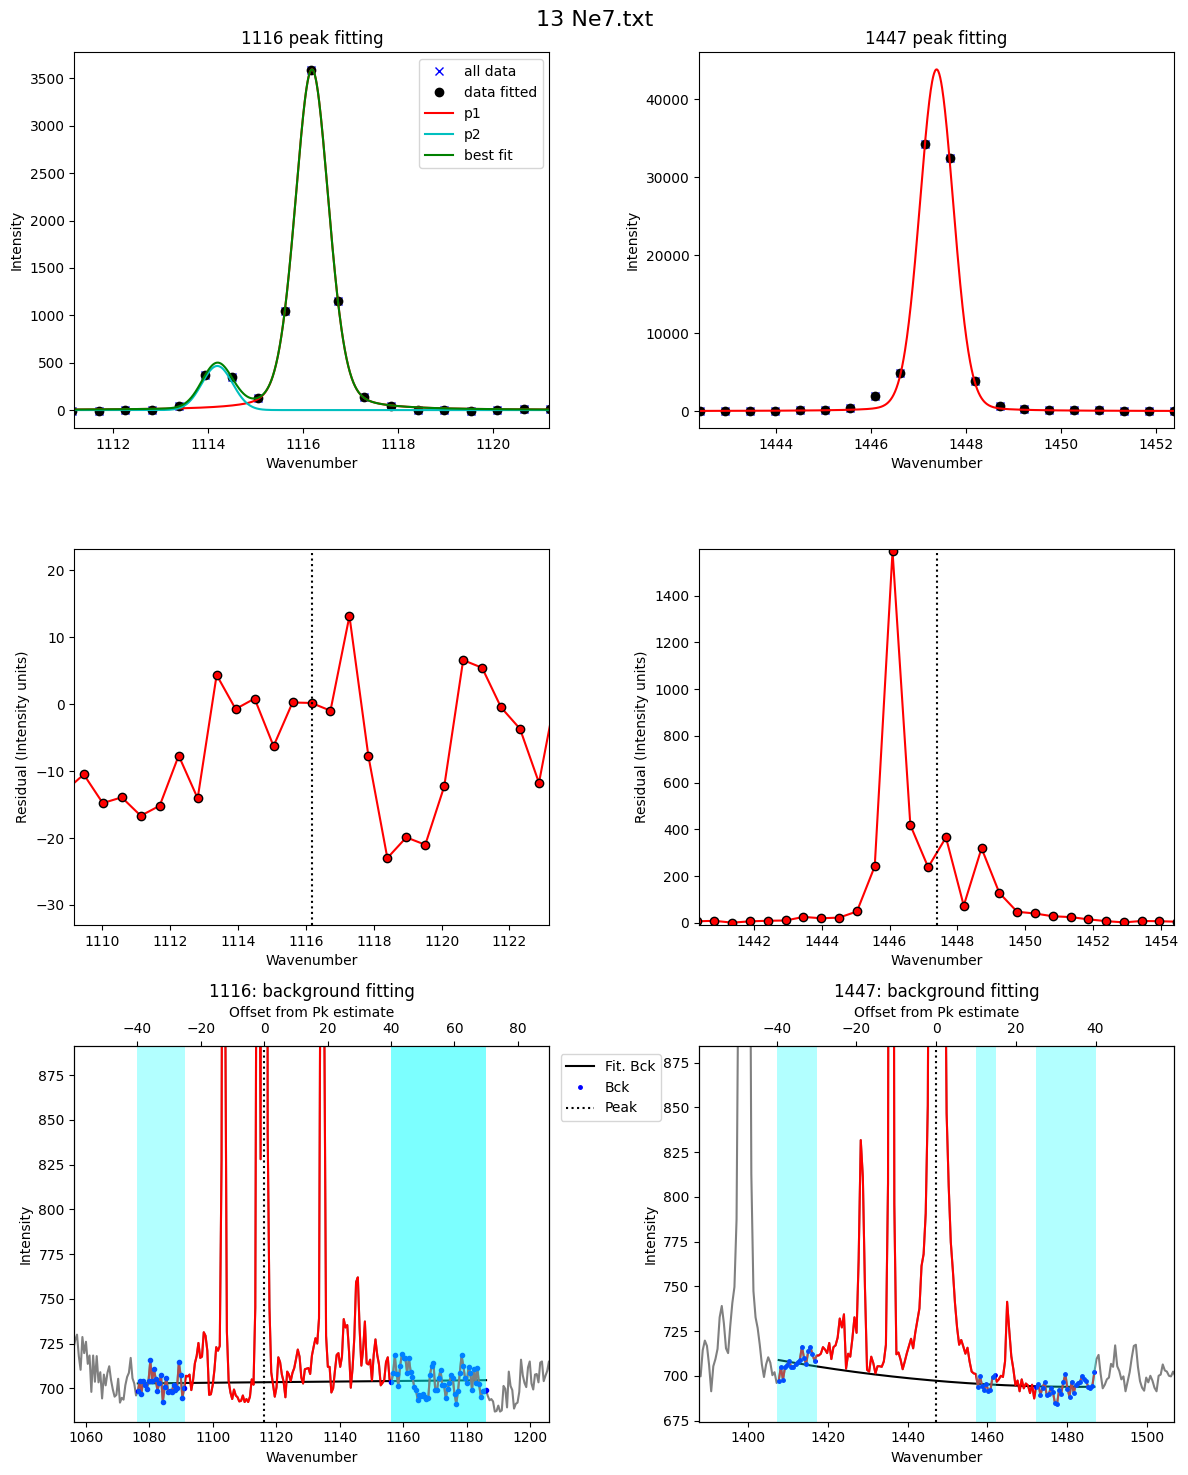

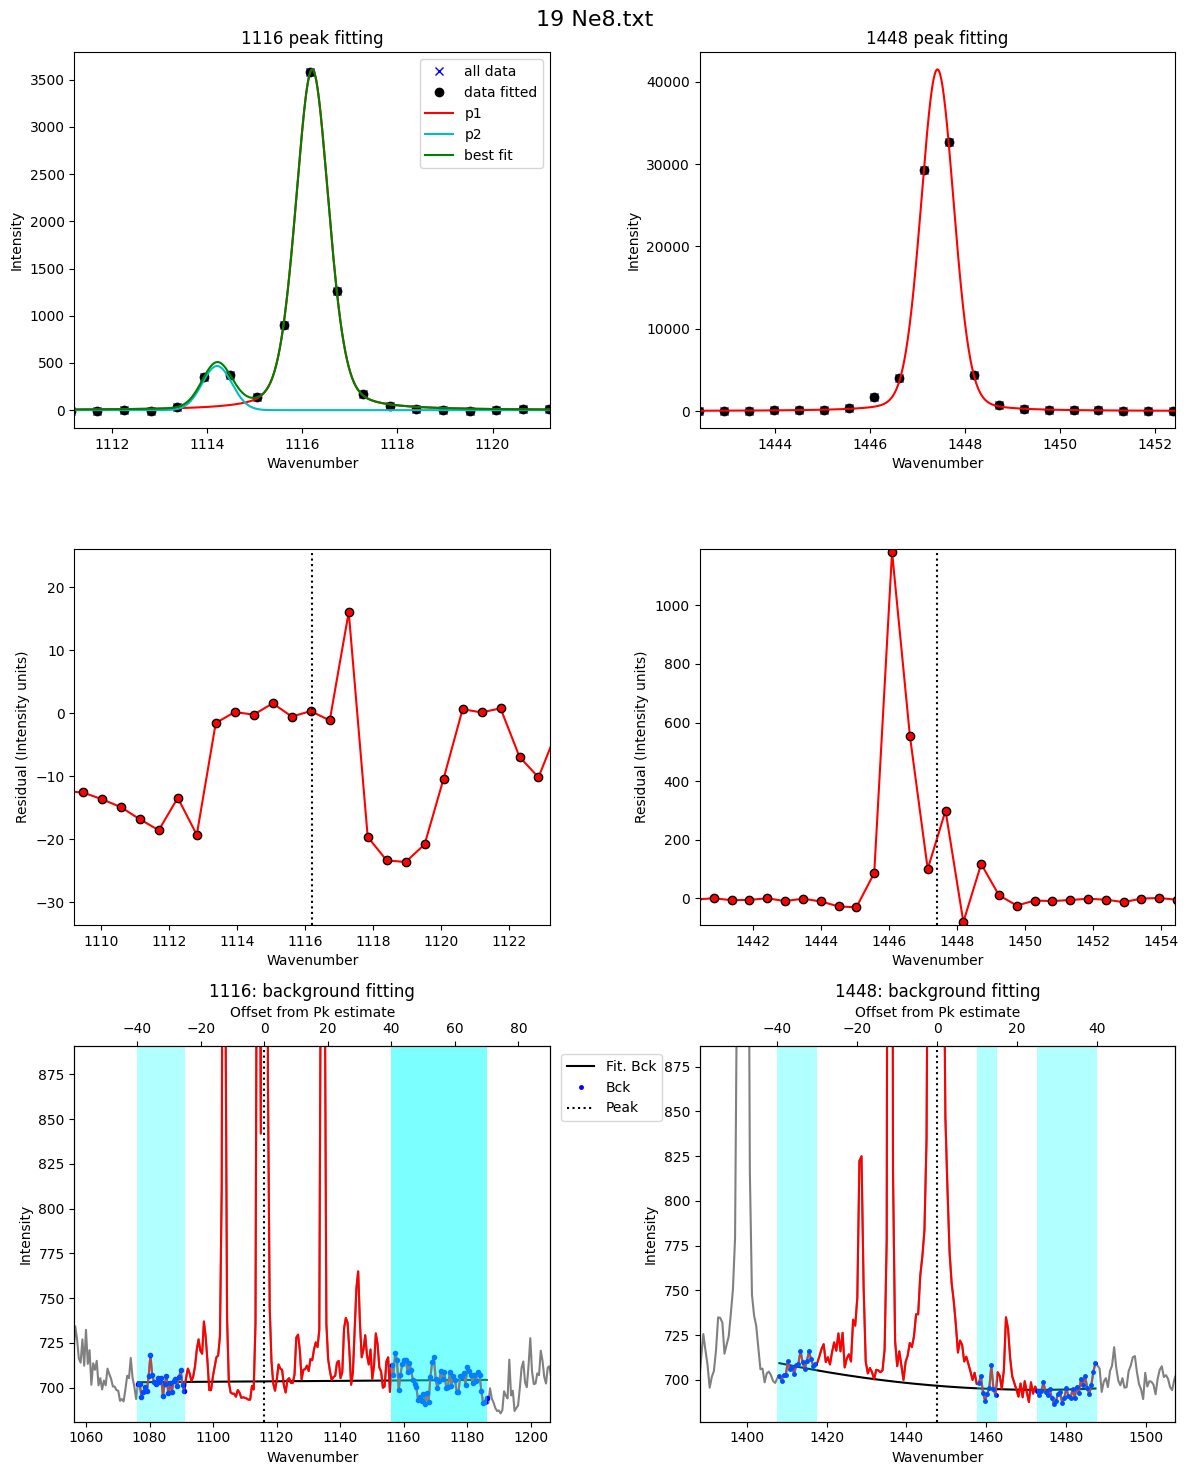

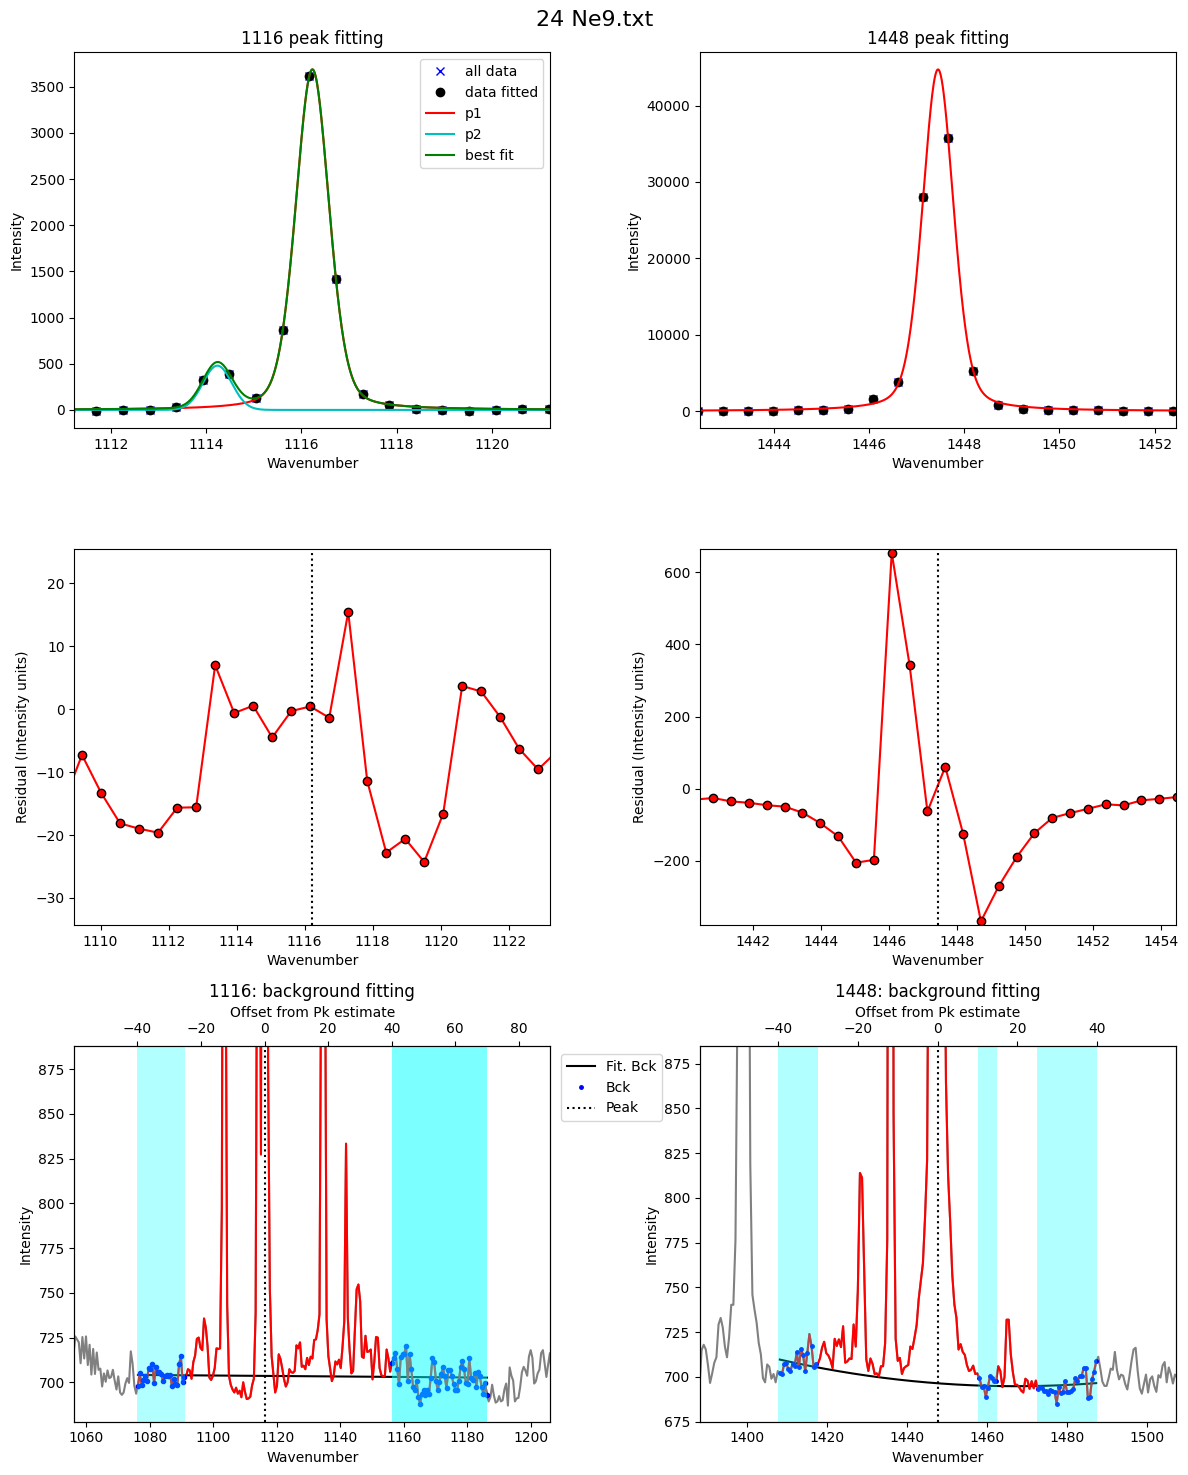

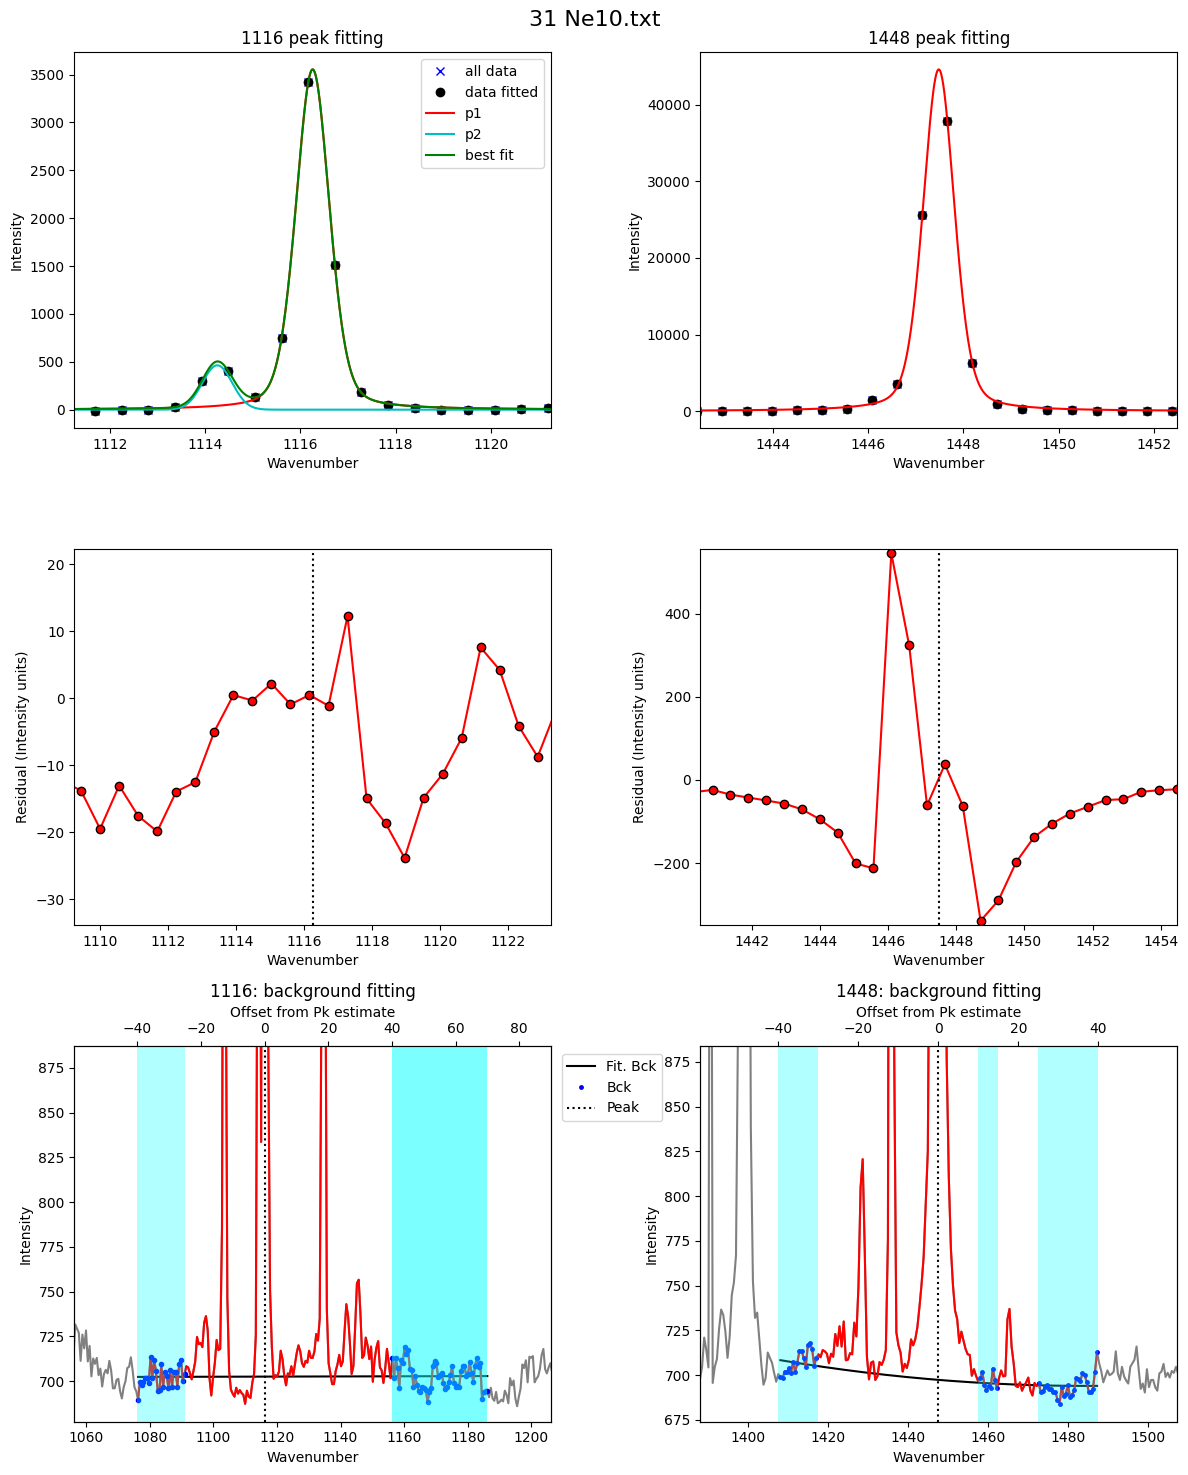

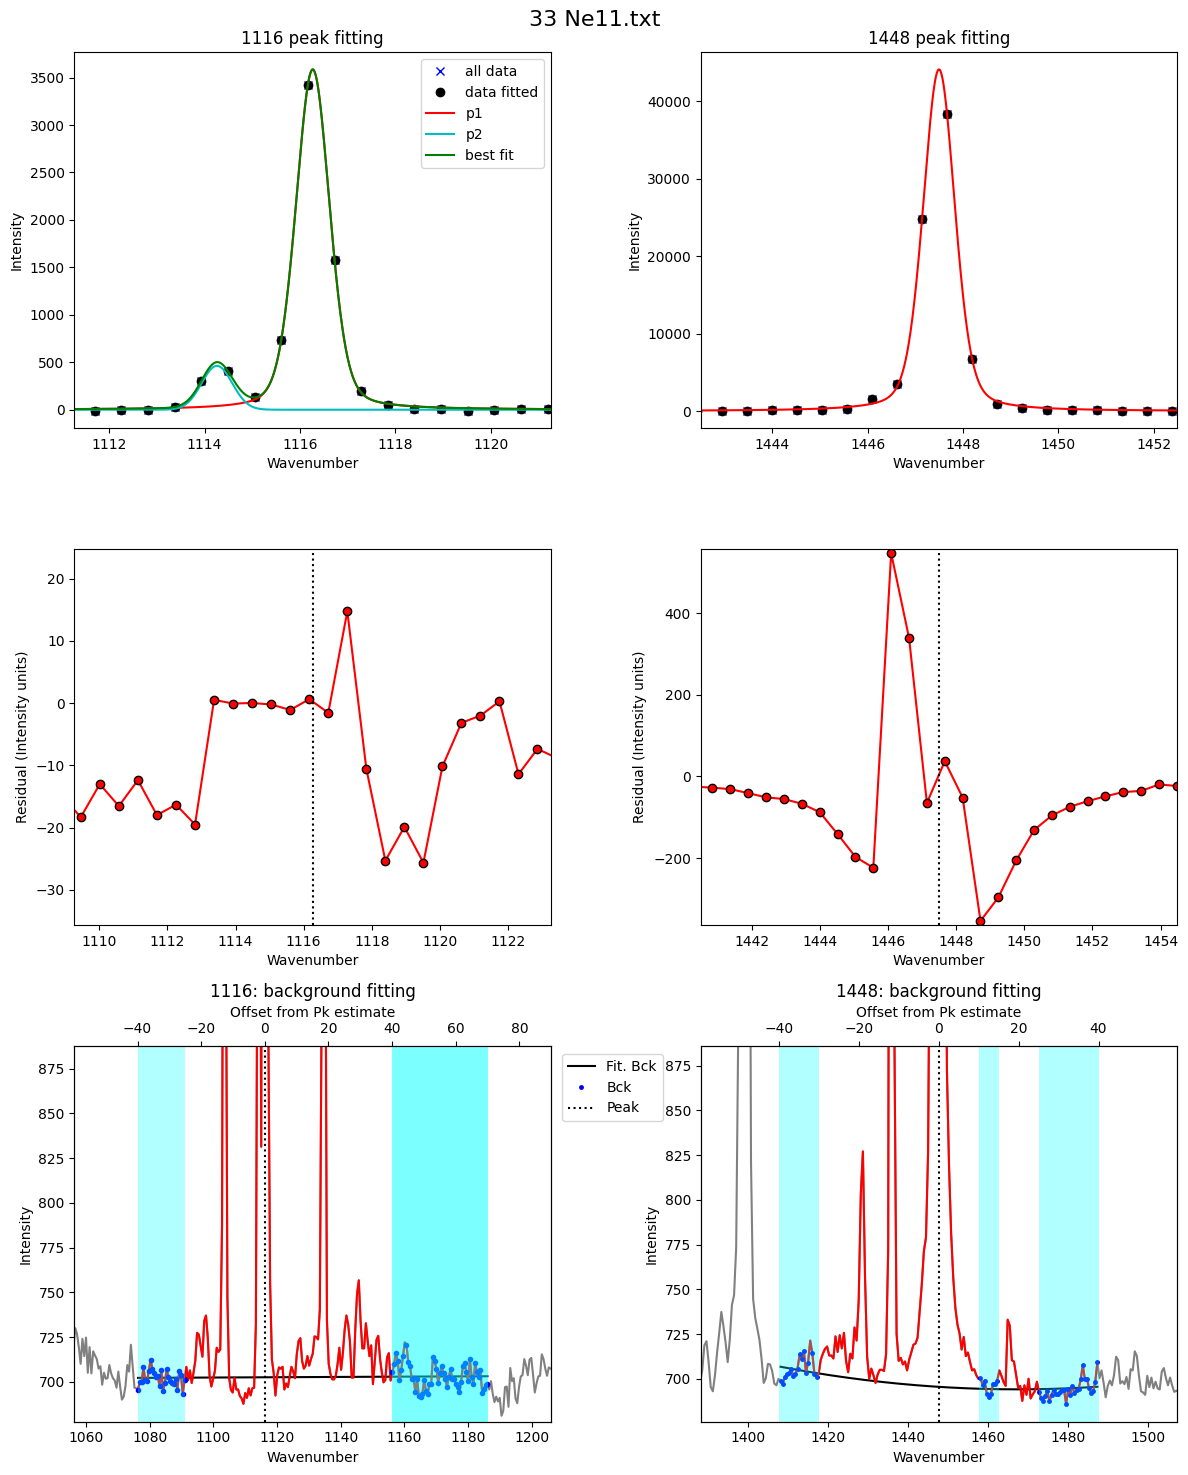

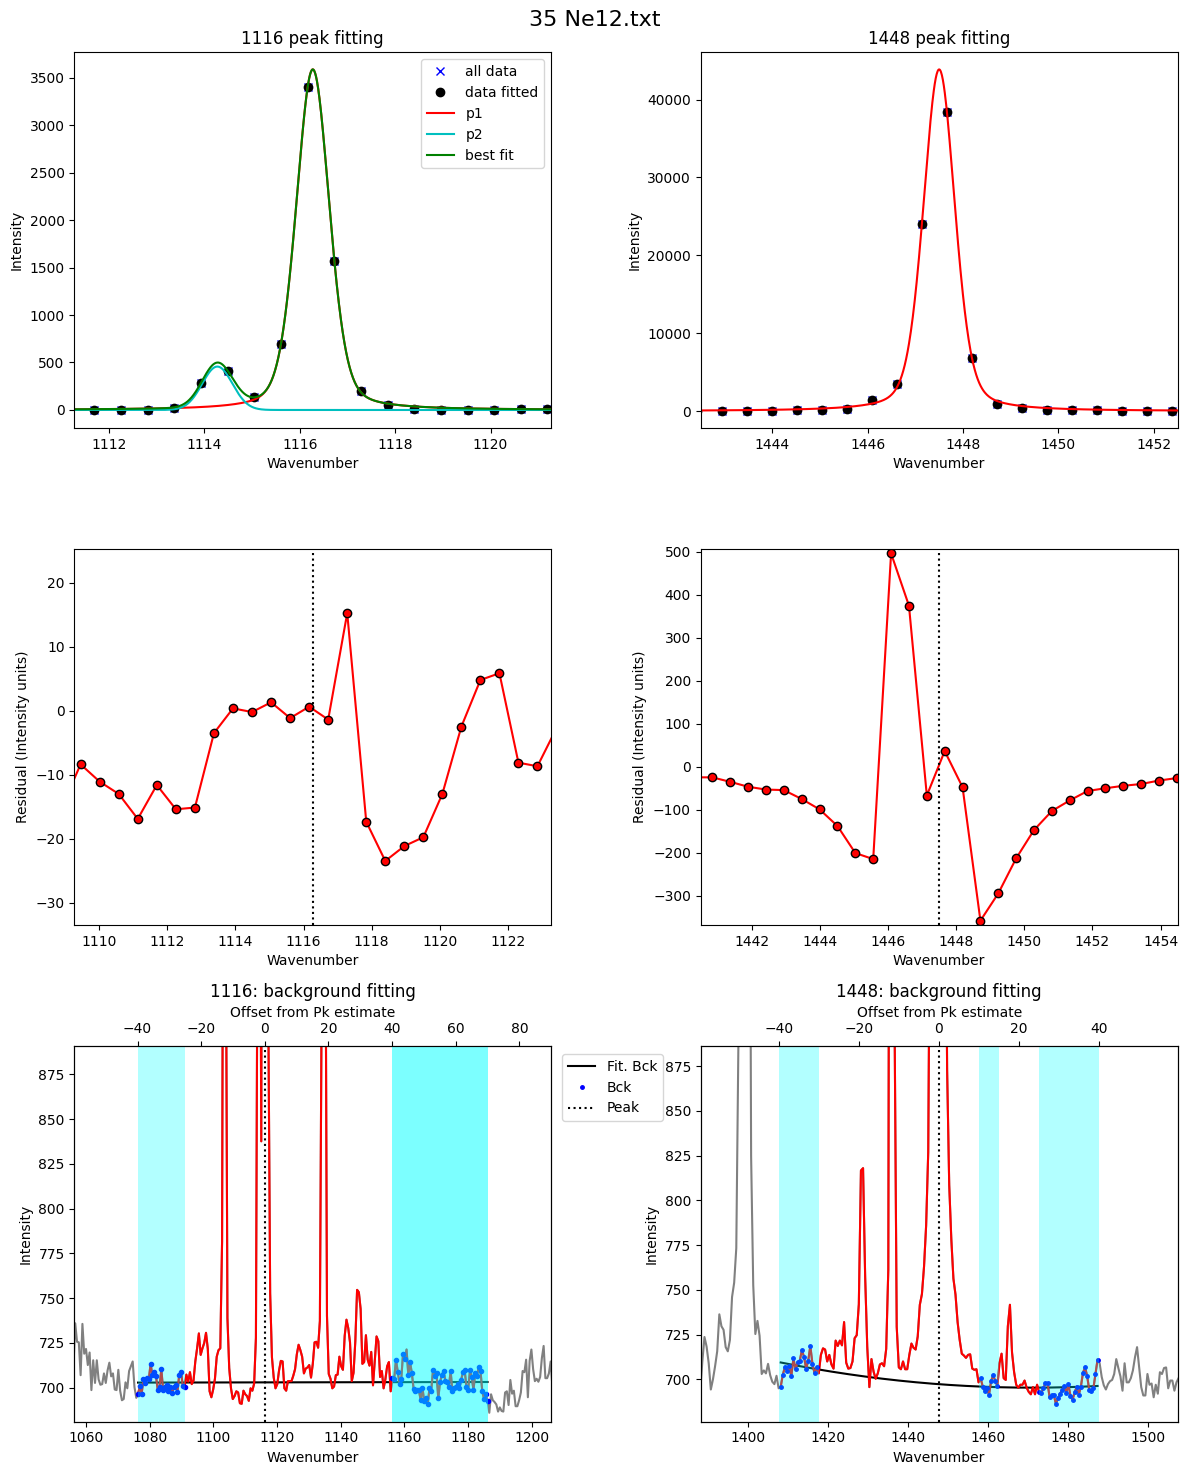

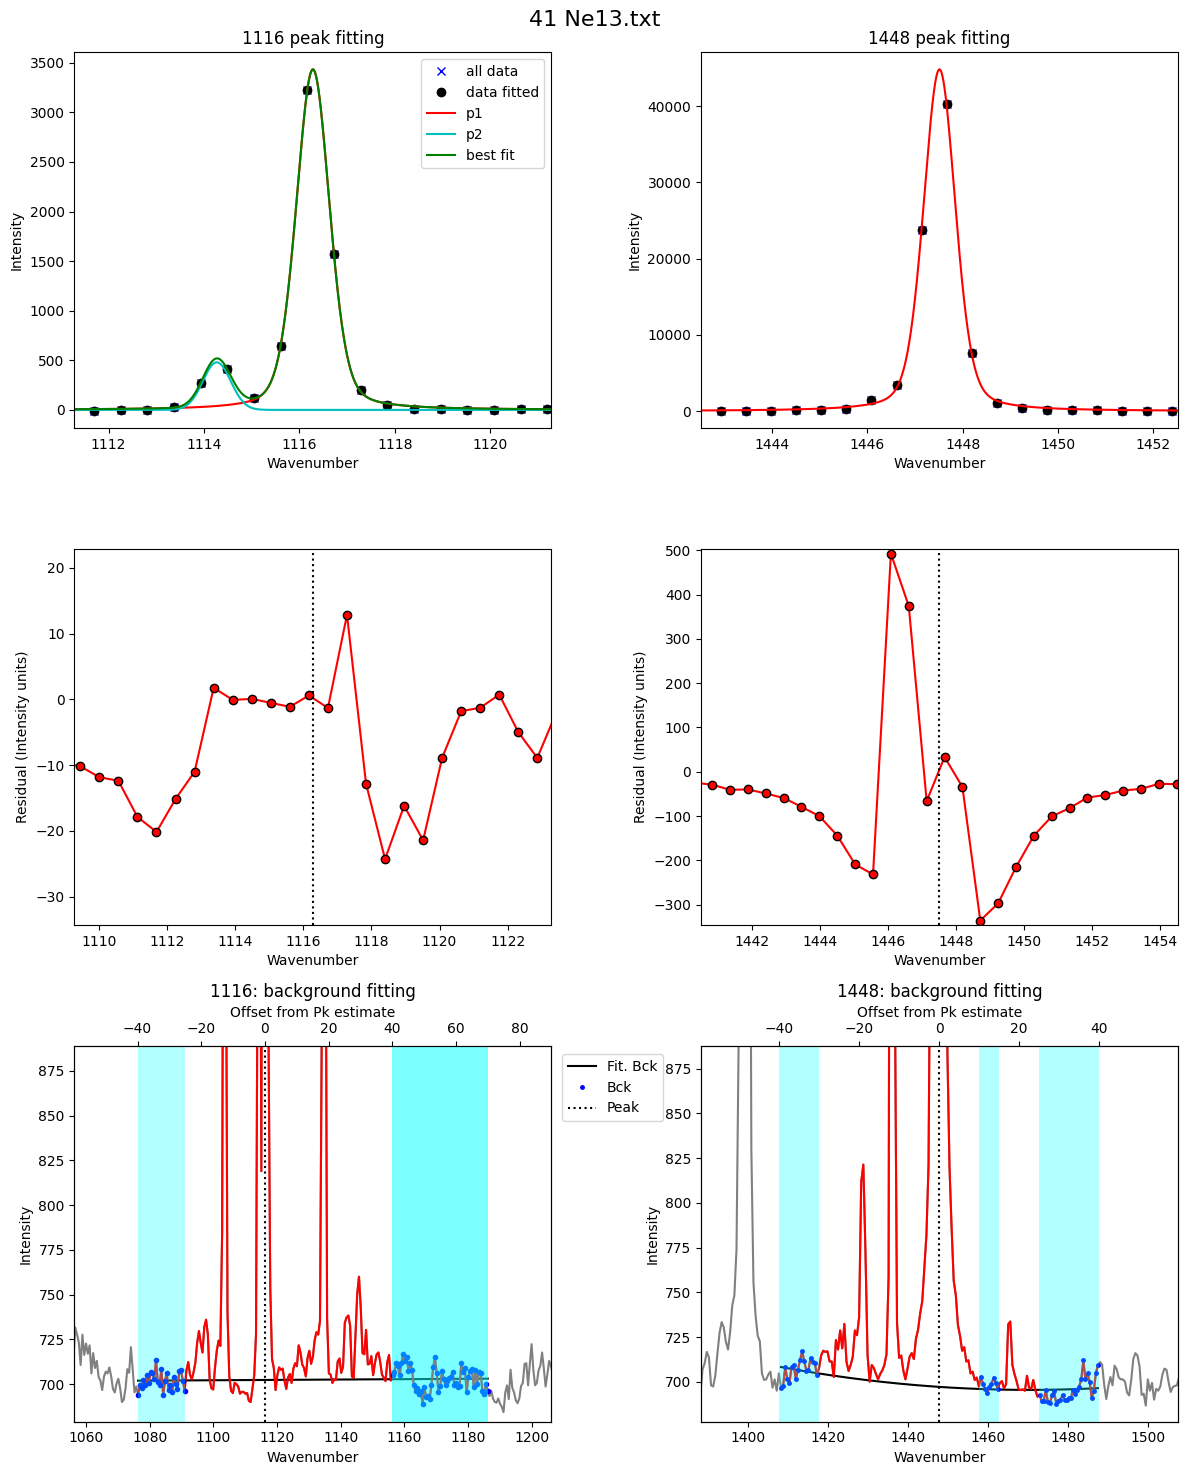

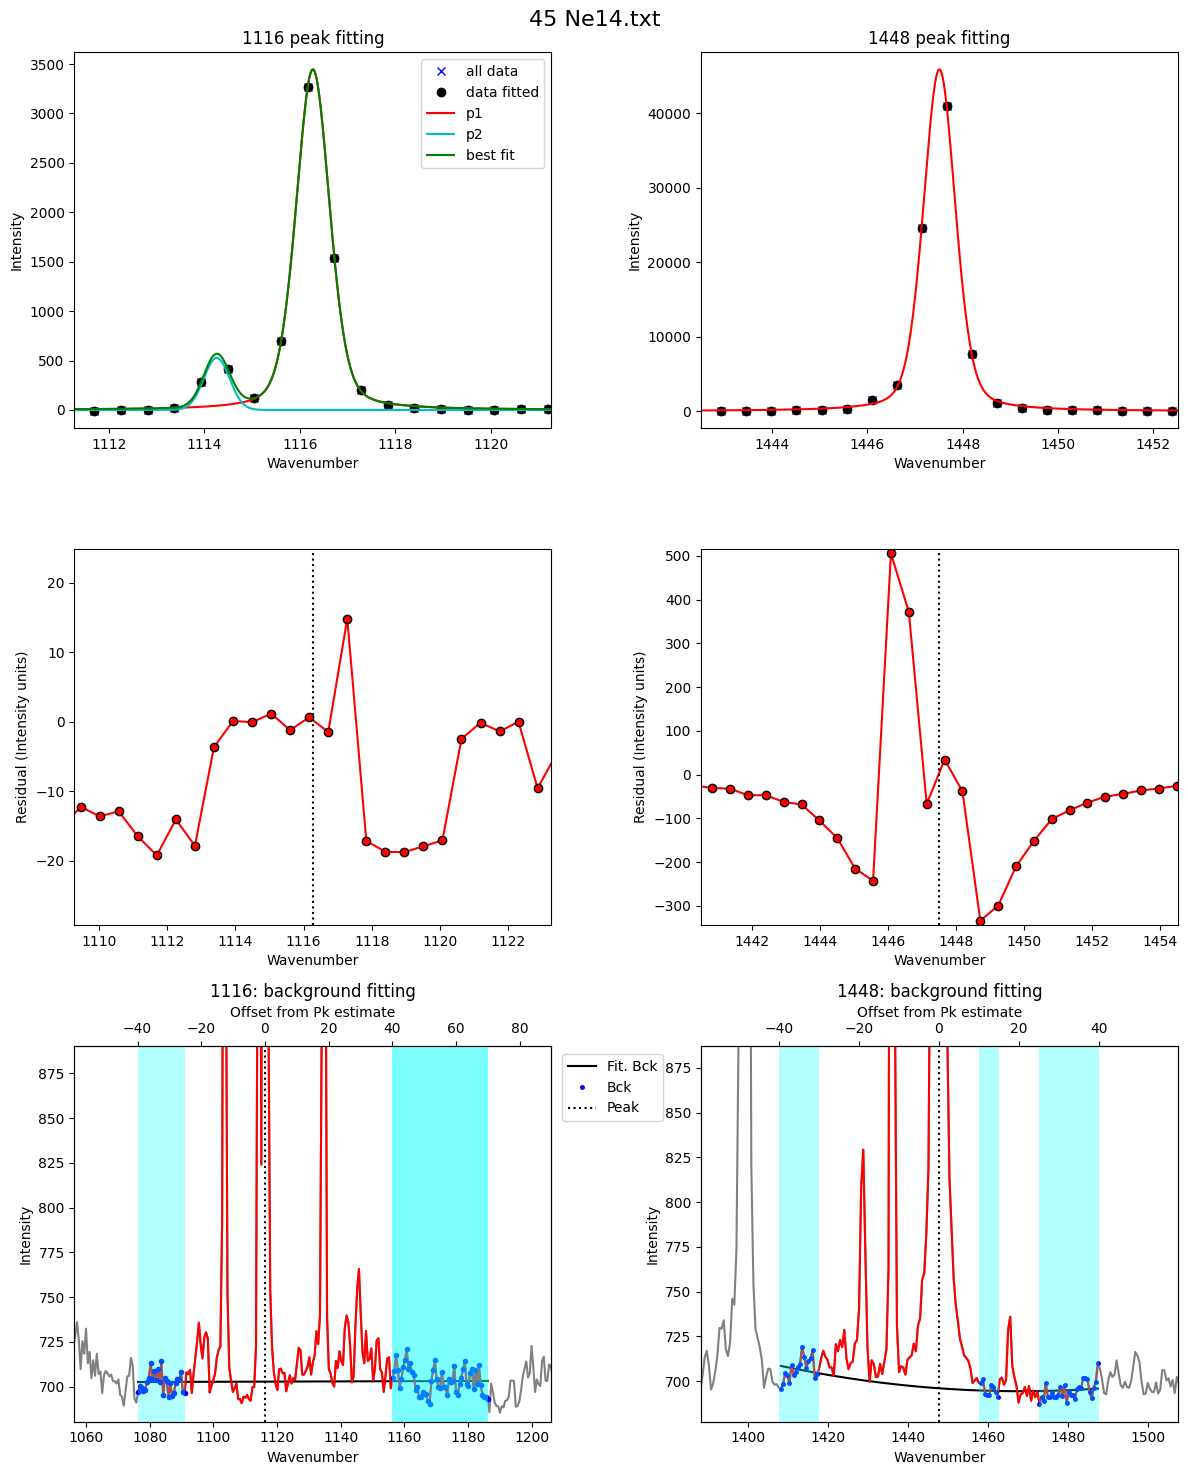

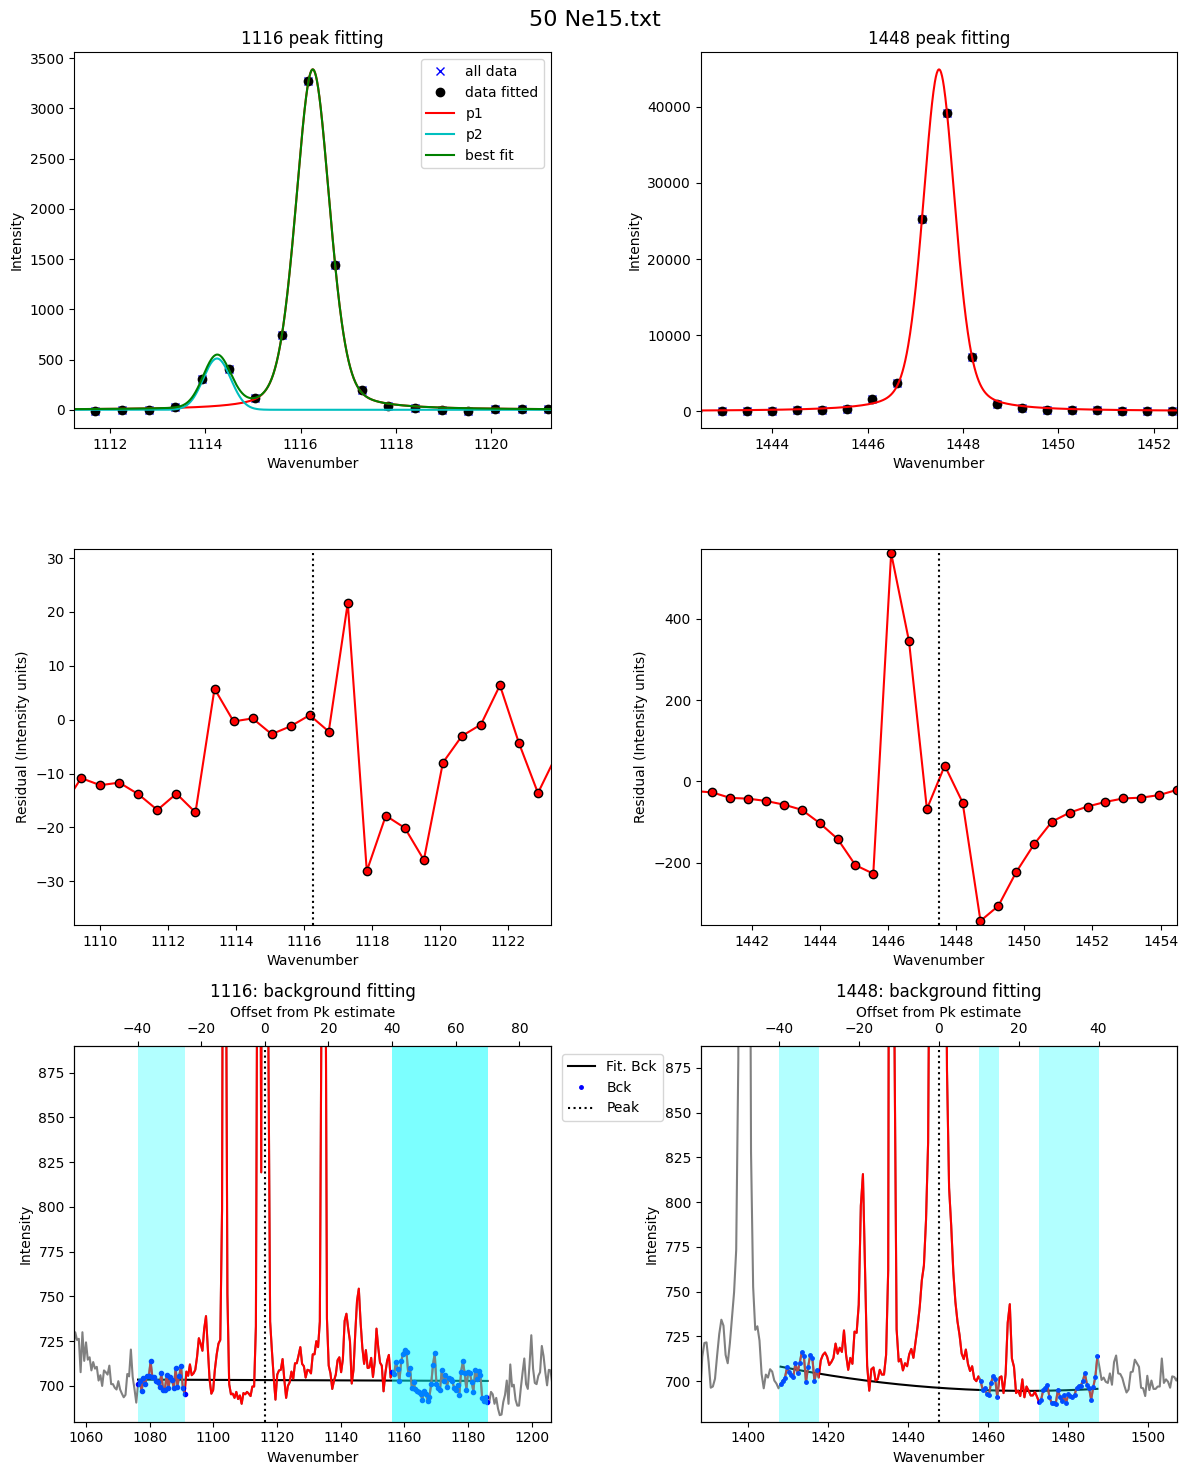

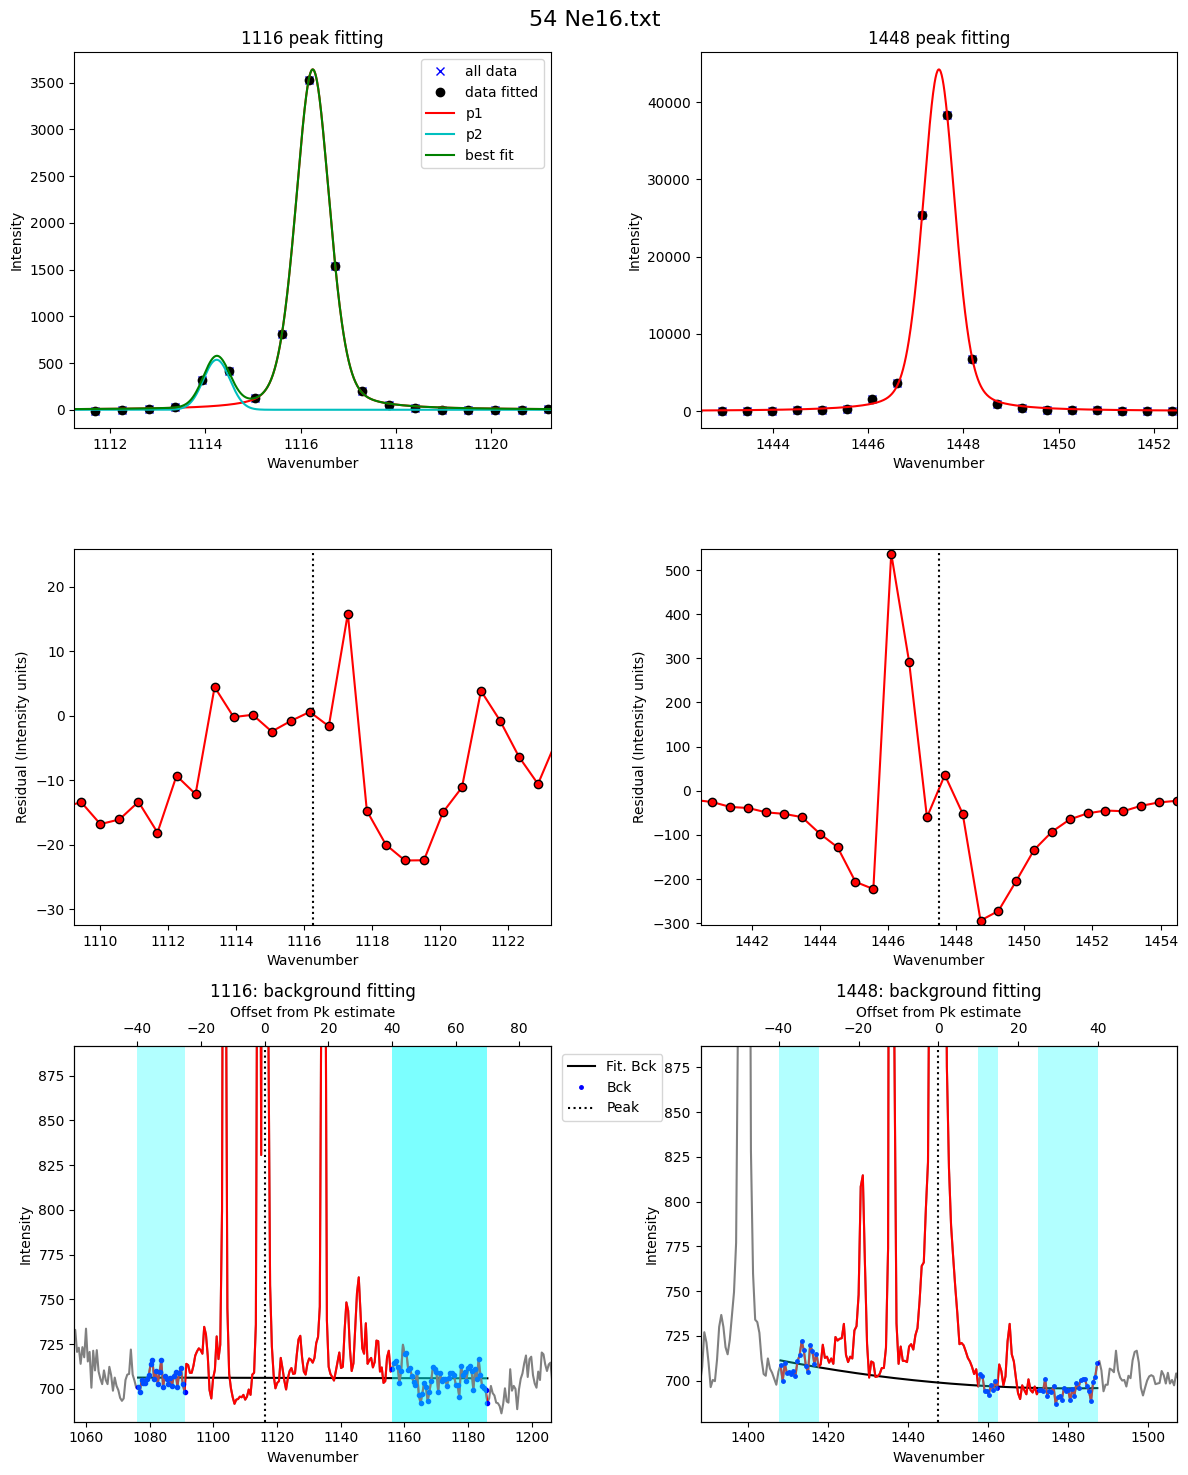

In [13]:
df2=pf.loop_Ne_lines(files=Ne_files, spectra_path=spectra_path, 
filetype=filetype, config_ID_peaks=Neon_id_config, config=Ne_Config_est,
df_fit_params=df_fit_params,  prefix=prefix,                   
plot_figure=True, const_params=True)


In [14]:
df2

filename   Ne_Corr  1σ_Ne_Corr     deltaNe  pk2_peak_cent  \
0                Ne1.txt  0.997809    0.000040  331.203261    1447.207055   
1                Ne2.txt  0.997813    0.000041  331.202030    1447.240933   
2   LL4-FI5-rep2+Ne3.txt  0.997822    0.000041  331.198898    1447.254391   
3                Ne4.txt  0.997812    0.000041  331.202256    1447.288436   
4                Ne5.txt  0.997795    0.000042  331.207835    1447.365330   
5                Ne6.txt  0.997798    0.000040  331.207096    1447.372752   
6                Ne7.txt  0.997794    0.000042  331.208283    1447.387109   
7                Ne8.txt  0.997773    0.000044  331.215209    1447.424615   
8                Ne9.txt  0.997760    0.000044  331.219491    1447.450369   
9               Ne10.txt  0.997748    0.000045  331.223505    1447.482464   
10              Ne11.txt  0.997743    0.000045  331.225257    1447.493614   
11              Ne12.txt  0.997736    0.000045  331.227529    1447.500209   
12              Ne13.txt  0.997725    0.000046  331.231061    1447.514095   
13              Ne14.txt  0.997706    0.000045  331.237344    1447.511153   
14              Ne15.txt  0.997700    0.000047  331.239517    1447.495028   
15              Ne16.txt  0.997706    0.000044  331.237496    1447.489699   

    pk1_peak_cent  pk2_amplitude  pk1_amplitude  residual_pk2  residual_pk1  \
0     1116.003794   42916.396358    3757.049070    100.976236      8.625083   
1     1116.038903   43313.292868    3755.072386     98.375594      7.773265   
2     1116.055493   43719.896913    3829.046190     94.556355      8.316913   
3     1116.086180   43005.091525    3777.019837     89.574624      8.687900   
4     1116.157496   42059.514286    3497.021443     70.414750      8.455932   
5     1116.165655   42994.987806    3693.571077     70.301409     10.052594   
6     1116.178826   40143.450772    3553.437627     96.081719      8.973701   
7     1116.209406   38370.539792    3581.541009     68.032815      9.332945   
8     1116.230877   41895.684453    3658.057165     94.368458     10.132982   
9     1116.258959   42173.180852    3556.622374     91.256473      9.559686   
10    1116.268356   42138.224825    3589.920064     90.828859      9.603665   
11    1116.272681   41808.069549    3572.539979     92.897597      9.367687   
12    1116.283034   43037.898980    3431.771431     93.213832      7.944310   
13    1116.273809   44095.285373    3485.569657     94.198600      8.951422   
14    1116.255511   43322.207672    3418.120876     94.837674     10.331083   
15    1116.252204   42595.317594    3692.144289     86.851069     10.305042   

    ...  pk2_gamma  error_pk2 Peak2_Prop_Lor  pk1_sigma  pk1_gamma  error_pk1  \
0   ...       None    0.00288       0.381910   0.411885       None   0.013095   
1   ...       None    0.00296       0.369983   0.414563       None   0.013208   
2   ...       None    0.00288       0.363828   0.411909       None   0.013177   
3   ...       None    0.00278       0.357677   0.411290       None   0.013166   
4   ...       None    0.00220       0.275800   0.413541       None   0.013674   
5   ...       None    0.00237       0.212730   0.414725       None   0.013126   
6   ...       None    0.00290       0.112694   0.417976       None   0.013657   
7   ...       None    0.00242       0.198395   0.410702       None   0.014484   
8   ...       None    0.00203       0.381355   0.414388       None   0.014421   
9   ...       None    0.00208       0.385169   0.415670       None   0.014634   
10  ...       None    0.00215       0.383733   0.417509       None   0.014582   
11  ...       None    0.00218       0.393724   0.411048       None   0.014722   
12  ...       None    0.00211       0.386112   0.413319       None   0.015049   
13  ...       None    0.00207       0.380603   0.415384       None   0.014710   
14  ...       None    0.00214       0.388054   0.419235       None   0.015351   
15  ...       None    0.00196       0.375878   0.420329       None

## Now extract metadata to get a timestamp for each file

In [15]:
## Get meta files
Ne_files_meta=pf.get_files(path=meta_path,
file_ext='txt', ID_str='Ne', 
exclude_str=['diad'], sort=False)

Ne_files_meta[0:5]

['004 Ne1.txt',
 '006 Ne2.txt',
 '007 LL4-FI5-rep2+Ne3.txt',
 '012 Ne4.txt',
 '017 Ne5.txt']

In [16]:
# This cell stitches metadata together - e.g. gets your laser power, time stamp, accumulations etc
meta=pf.stitch_metadata_in_loop_witec(path=meta_path, 
Allfiles=Ne_files_meta, prefix=prefix, trupower=TruPower)
meta.head()

100%|██████████| 16/16 [00:00<00:00, 152.77it/s]

Done


filename                date    Month   Day  power (mW)  \
0               Ne1.txt  October 17, 2022\n  October  17.0       5.998   
1               Ne2.txt  October 17, 2022\n  October  17.0       6.029   
2  LL4-FI5-rep2+Ne3.txt  October 17, 2022\n  October  17.0       6.097   
3               Ne4.txt  October 17, 2022\n  October  17.0      11.935   
4               Ne5.txt  October 17, 2022\n  October  17.0      12.063   

   Int_time (s)  accumulations  Mag (X)             duration      24hr_time  \
0          45.0            3.0     50.0  ['0h', '2m', '17s']  10:23:21 AM\n   
1          45.0            3.0     50.0  ['0h', '2m', '16s']  10:33:01 AM\n   
2          45.0            5.0     50.0  ['0h', '3m', '46s']  10:37:34 AM\n   
3          45.0            3.0     50.0  ['0h', '2m', '16s']  10:54:35 AM\n   
4          45.0            3.0     50.0  ['0h', '2m', '16s']  11:56:24 AM\n   

   sec since midnight  Spectral Center  
0             37401.0         1325.004  
1             37981.0         1325.004  
2             38254.0         1325.004  
3             39275.0         1325.004  
4             42984.0         1325.004

In [17]:
# This is getting the metadata file names.  Check here the prefix has been removed. 
file_m=pf.extracting_filenames_generic(names=meta['filename'], 
   file_ext='.txt')
file_m

good job, no duplicate file names


array(['Ne1', 'Ne2', 'LL4-FI5-rep2+Ne3', 'Ne4', 'Ne5', 'Ne6', 'Ne7',
       'Ne8', 'Ne9', 'Ne10', 'Ne11', 'Ne12', 'Ne13', 'Ne14', 'Ne15',
       'Ne16'], dtype=object)

In [18]:
# This is getting the spectra file names. Check that they are in the same format as the metadataones above, this is what you need to successfully stitch together. 
file_s=pf.extracting_filenames_generic(names=df2['filename'],
   file_ext='.txt')
file_s

good job, no duplicate file names


array(['Ne1', 'Ne2', 'LL4-FI5-rep2+Ne3', 'Ne4', 'Ne5', 'Ne6', 'Ne7',
       'Ne8', 'Ne9', 'Ne10', 'Ne11', 'Ne12', 'Ne13', 'Ne14', 'Ne15',
       'Ne16'], dtype=object)

## Combine 2 dataframes
- Here we add a new column to each dataframe with these stripped back names, and then merge the 2 dataframes

In [19]:
meta['name_for_matching']=file_m
df2['name_for_matching']=file_s
df_combo=df2.merge(meta, on='name_for_matching')

## Now lets inspect changes in Ne correction factor with time
- Normally, you can spot outliers this way

In [20]:
df_combo_sort=df_combo.sort_values(by='sec since midnight')
df_combo_sort.to_excel('PseudoVoigt.xlsx')

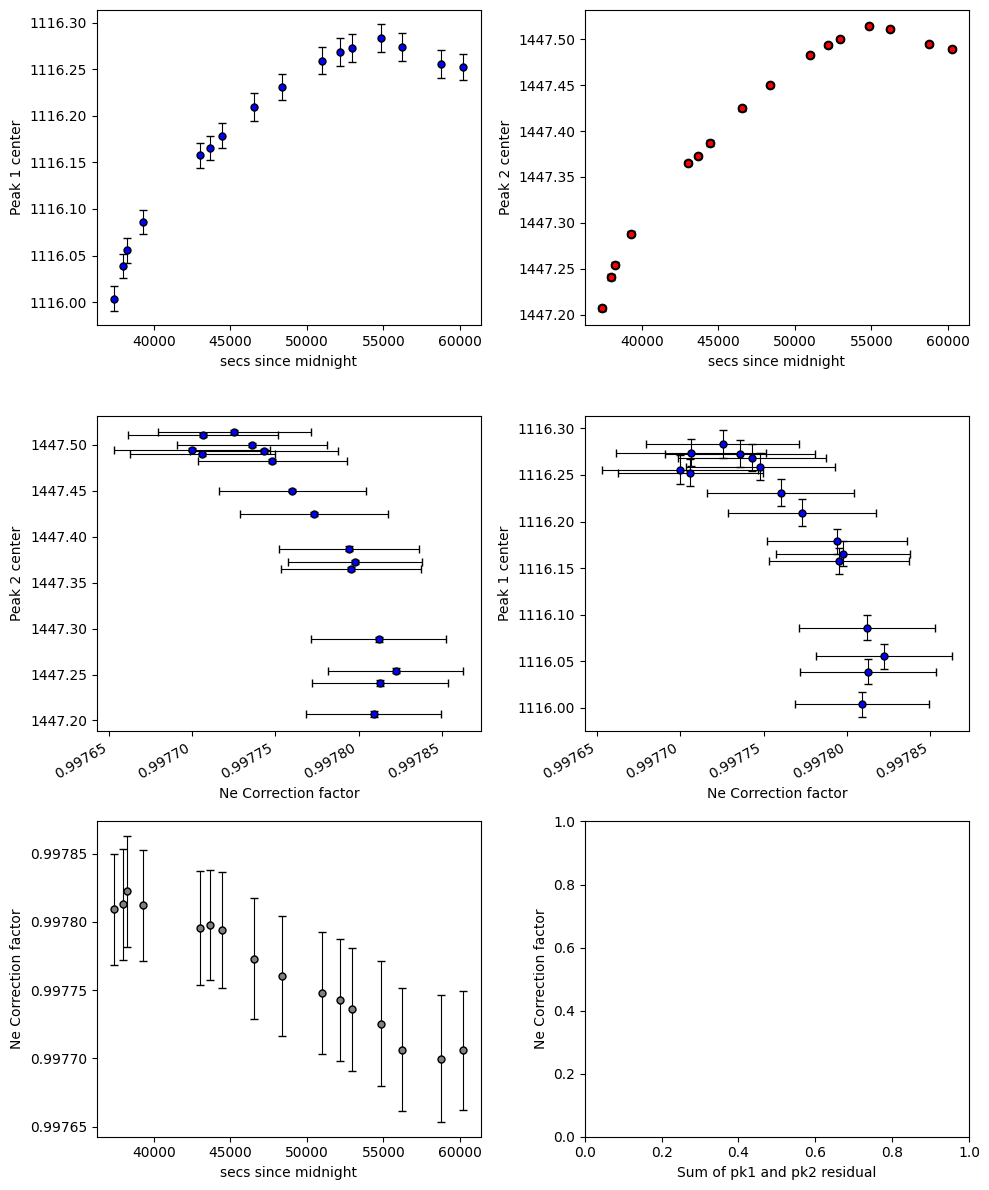

In [21]:
fig=pf.plot_Ne_corrections(df=df_combo, x_axis=df_combo['sec since midnight'],
                      x_label='secs since midnight')


## Exclude ones that don't look right...
- The filter_Ne_Line_neighbours excludes Ne lines that have a correction factor more than "offset" from their N neighbours (defined by "number_av")
- Tweak offset and number_av until you exclude the ones that dont look right
- Smaller number of offset - more discarded
- If you notice really bad fits, you can also exclude certain files like file_name_filt=['Ne_line_1.txt'], or file_name_filt=['Ne_line_2.txt', 'Ne_line_5.txt']

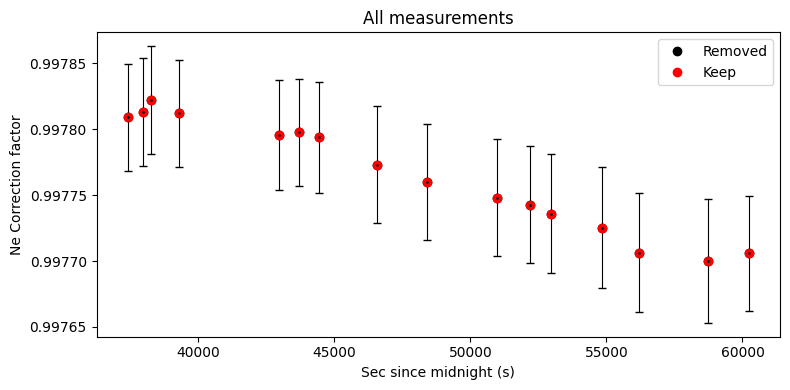

In [22]:
filt=pf.filter_Ne_Line_neighbours(df_combo=df_combo, 
                    number_av=3, offset=0.001, file_name_filt=None)
# Now lets plot this to see
fig, (ax1) = plt.subplots(1, 1, figsize=(8,4))
ax1.errorbar(df_combo['sec since midnight'], df_combo['Ne_Corr'], xerr=0, 
yerr=df_combo['1σ_Ne_Corr'], fmt='d', ecolor='k', elinewidth=0.8, mfc='cyan', ms=1, mec='k', capsize=3)
ax1.plot(df_combo['sec since midnight'], df_combo['Ne_Corr'],   'ok', label='Removed')
ax1.plot(df_combo['sec since midnight'], filt,  'or', label='Keep')

ax1.legend()

ax1.set_xlabel('Sec since midnight (s)')
ax1.set_ylabel('Ne Correction factor')
ax1.set_title('All measurements')

fig.tight_layout()

## Now lets make a regression against time
- We take this time regression and then apply to our diad fits

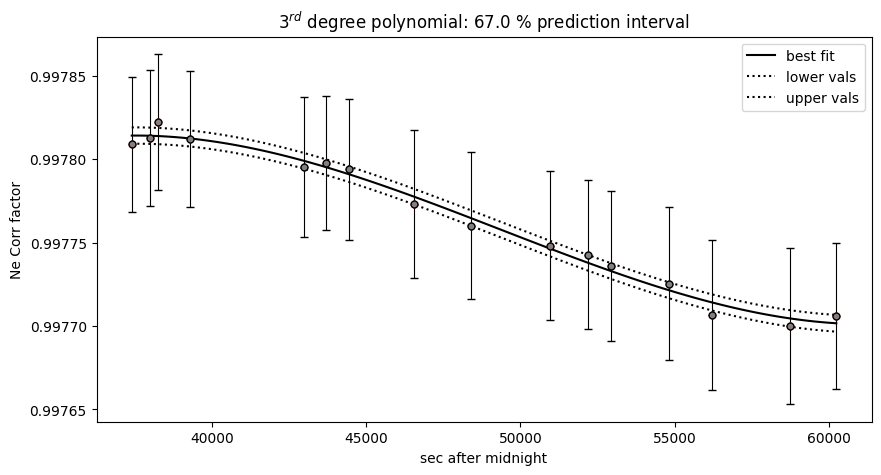

In [24]:

big_err=df_combo['1σ_Ne_Corr']>0.0001
## Lets get filtered ones
keep=(filt>0)&(~big_err)

pf.generate_Ne_corr_model(time=df_combo['sec since midnight'].loc[keep], Ne_corr=df_combo.loc[keep], 
N_poly=3, CI=0.67, pkl_name='Neon_corr_model.pkl')
